In [4]:
from gradient_descent import gradient_descent, minibatch_class
import utils
from utils import Poisson_reg
from utils import sample_PLN

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from timeit import default_timer as timer
from tqdm import tqdm 
import time 
import sys 

from __future__ import print_function
import psutil
import multiprocessing
import concurrent.futures
import threading

import numpy as np
import torch
from torch import nn
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
torch.set_default_dtype(torch.float64)

In [68]:
class PLN_full():
    def __init__(self, C_init, beta_init, M_init, S_init, requires_tridiag = True): 
        '''
            Initialization : 
            'Y' : the data, size (n,p). n is the number of samples we have and p the number of species. 
                  the entries should be int but dtype = float. 
            'O': offset : additional offset. (not very important for comprehension). size (n,p)
            'covariates' : covariates, size (n,d)
            'C_init' : initialization for C. I plan to do a more advanced initialization. 
            'beta_init ' : Initialization for beta. I plan to do a more advanced initialization. 
            'M_init' : initialization for the variational parameter M
            'S_init ': initialization for the variational parameter S
            'requires_tridiag' : bool. If True, the parameters C wil be a vector 
                                of size (n(n+1)/2). It will form a lower tridiagonal matrix after,
                                but we encode it as a vector for pytorch. Advantages : we get about half less 
                                parameter if True. 
                                If False, C will be a Matrix of size (n,n). It won't be a lower tridiagonal Matrix
                                after some gradient steps. 
        '''
        # model parameters
        
        # we start with the initialization of C, that is the most subtle. If you want tridiagonals matrices 
        # at every iteration then the parameters C of the optimizer will be a vector ( we will change this vector 
        # into a matrix at each iteration to compute the loss. It is more convenient this way. 
        #Else, it will be a matrix

        
        if requires_tridiag : 
            self.C = torch.clone(mat2vec_lower_tridiag(C_init))
            self.requires_tridiag = True 
        else : 
            self.C = torch.clone(C_init) 
            self.requires_tridiag = False 
            
        self.C.requires_grad_(True)
        self.Sigma = torch.clone(torch.mm(C_init,C_init.T))
        self.Sigma.requires_grad_(False) # we don't need to have a gradient for Sigma since we will 
                                         # always update it with a closed form (since we have constraints
                                         # of positivity and symmetry)
        #note that C and sigma have a similr role here. We will use either C or Sigma 
        #depending on the loss we choose. 
        
        self.beta = torch.clone(beta_init)
        self.beta.requires_grad_(True)
        
        #variational parameters
        self.M = torch.clone(M_init)
        self.M.requires_grad_(True)
        self.S = torch.clone(S_init) 
        self.S.requires_grad_(True)
        
        
        
        self.params = {'S' : self.S,'M' : self.M,'C' : self.C, 'beta' : self.beta}
        
        #optimizer for the full gradient ascent, i.e gradient ascent 
        # on (M,S,C,beta)
        self.optimizer = torch.optim.Adam(self.params.values(), lr = 0.002)
        #optimizer for a VEM where the M-step uses closed form for beta and Sigma
        self.VEM_full_closed_optimizer = torch.optim.Adam([self.S,self.M], lr = 0.002)
        #optimizer for a VEM chere the M-step uses optimization for C, 
        #and a closed form for beta
        self.VEM_beta_closed_optimizer = torch.optim.Adam([self.S,self.M,self.C], lr = 0.002)
        #optimizer for a VEM where the M-step uses optimization for beta, 
        #and a closed form for Sigma
        self.VEM_Sigma_closed_optimizer = torch.optim.Adam([self.S,self.M,self.beta], lr = 0.002)
        
        self.params['Sigma'] = self.Sigma
        
        self.old_loss = 1
        
        # some list to store some stats
        self.t0 = time.time()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.ELBO_list = list()
        self.running_times = list()

        
    def extract_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. 
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0];self.O = data[1];self.covariates = data[2]
        self.n, self.p = self.Y.shape
        
    def compute_ELBO(self): 
        '''
        compute the ELBO with the parameter of the model we have extract. 
        This ELBO uses the parametrization for Z ~ N(XB,Sigma)
        '''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_tridiag(self): 
        '''
        same function as above, but the parameter C is a vector here. 
        it does the same but changes C from a vector to a lower tridiagonal Matrix. 
        '''
        return ELBO_tridiag(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    def compute_ELBO_Sigma(self): 
        '''
        Computes the ELBO when Sigma is the parameter, (in opposition to C)
        '''
        return ELBO_Sigma(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    def full_grad_ascent(self,data, lr = 0.1, N_epoch = 1000, verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta)
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        # we extract the data
        self.extract_data(data)
        
        #we choose the right loss. Note that both loss uses C and not Sigma. 
        #if we have chosen a tridiagonal matrix : 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : # if we have not chosen a tridiagonal matrix,
            gain = self.compute_ELBO
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, gain,self.params, lr = lr,
                            tolerance = 0 , N_epoch = N_epoch,requires_closed_Sigma= False,verbose = verbose)
    def VEM_full_closed(self,data,Number_VEM_step,N_epoch_max = 20,  lr = 0.1, tolerance = 0.1, verbose = True ): 
        '''
        VEM where we use the closed form both of Sigma and beta. As a result, 
        the M-step is straightforward as we only choose update beta and sigma once. 
        The VE-step uses optimization.
        
        args : same as above except : 
              -'tolerance' : float. Threshold 
              that tells when to stop. If the gain have not improved 
              of more than tolerance, then we stop the VE step. 
              The tolerance of the first step will start at tolerance, 
              but will be decreased at each iteration at a factor of 1/i. 
              -'Number_VEM_step' int. The number of times we will do a VE and a M step.   
        
        '''
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        for i in range(Number_VEM_step): 
            # VE step. We choose the gain that uses Sigma and not C. 
            self.torch_gradient_ascent(self.VEM_full_closed_optimizer, self.compute_ELBO_Sigma,self.params, 
                            lr = lr, tolerance = tolerance/(i+1),N_epoch = N_epoch_max,
                            requires_closed_Sigma= True, verbose = verbose)
            #M_step 
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            
    def VEM_beta_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.1, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update beta with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,C)
        for N_epoch_max iteration and then update beta.
        args : same as above. 
        '''
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        # choose the right loss. Note that the loss uses C here. 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : 
            gain = self.compute_ELBO
            
        for i in range(Number_VEM_step): 
            #gradient ascent for N_epoch_max iteration maximum. 
            self.torch_gradient_ascent(self.VEM_beta_closed_optimizer, gain ,self.params, 
                lr = lr, tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= False, verbose = verbose)
            #update beta
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
            
    def VEM_Sigma_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.1, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update Sigma with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.extract_data(data)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.VEM_Sigma_closed_optimizer, self.compute_ELBO_Sigma,self.params, 
                lr = lr, tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= True, verbose = verbose)
            with torch.no_grad():
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            
    
            
            
    def torch_gradient_ascent(self, optimizer, compute_gain,params,  lr , tolerance , N_epoch ,  requires_closed_Sigma, verbose): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 

        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 

                'compute_gain' : function. It should call the parameters by itself. i.e. we wil 
                                all compute_gain() without any parameter in argument. 

                'lr' : float.  a learning rate if we want to set the optimizer learning rate to a certain lr. 
                       If None, it will take the actual learning_rate of the optimizer. 
                       
                'tolerance': float. the threshold we set to stop the algorithm. It will 
                              stop  if we are not improving the loss more than tolerance. 
                              
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                
                'requires_closed_Sigma' : bool. tells if we are using Sigma (True) or C(False). 
                                          Here just to keep track of the error.
                                          between self.Sigma and true_Sigma

                'Verbose' : bool. if True, will print some messages useful to 
                            interpret the gradient ascent. If False, nothing will be printed. 
 
        returns : None 
        '''
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5,patience = 3)
        # we set the gradient to zero just to make sure the gradients are properly calculated
        optimizer.zero_grad()
        if lr is not None : # if we want to set a lr, we set it. Ohterwise, we skip this condition and keep the actual learning_rate
            optimizer.param_groups[0]['lr'] = lr 

        stop_condition = False 
        i = 0

        while i < N_epoch and stop_condition == False: 
            optimizer.zero_grad()
            loss = -compute_gain()
            loss.backward()
            #print('sanity check : ', torch.norm(params['C'].grad+grad_C(data[0], data[1],data[2] ,params['M'] ,params['S'] ,params['C'] ,params['beta']) ))
            if torch.isnan(loss).item() == True : 
                print('NAN')
            optimizer.step()
            #scheduler.step(loss.item())
            
            
            delta = self.old_loss - loss.item() 
            '''
            if delta < 0 : 
                print('We regressed of ', delta )
            else : 
                print('We gain ', delta )
            '''
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            
            self.old_loss = loss.item()
            
            # keep track of the error with Sigma. 
            if requires_closed_Sigma : # if we use Sigma as parameter 
                self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            else : #if we use C 
                if len(params['C'].shape) > 1 : # C is a matrix ( requires_tridiag = False)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(self.C,self.C.T)-true_Sigma)**2).item())
                else : # C is a vector (requires_tridiag = true)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(vec2mat_lower_tridiag(self.C),
                                                           vec2mat_lower_tridiag(self.C).T)-true_Sigma)**2).item())

            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.ELBO_list.append(-loss.item())
            # print some stats if we want to
            if i%100 == 0 and verbose : 
                print('iteration number: ', i)
                print('-------UPDATE-------')
                print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
                print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
                print('ELBO : ', np.round(-loss.item(),5))
                print('Delta : ', delta)
                #print_stats(loss, params, optimizer)
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)

        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch, 'last delta = ', delta)
            #print_stats(loss, params, optimizer)  
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))


In [61]:
def print_model(model):
    n,p = model.Y.shape
    d = model.beta.shape[0]
    
    abscisse = model.running_times
    fig,ax = plt.subplots(3,1,figsize = (15,12))
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, model.MSE_Sigma_list, label = 'MSE Sigma')
    ax[0].legend()
    ax[0].set_ybound( lower=0, upper=0.7)
   
    ax[1].plot(abscisse, model.MSE_beta_list, label = 'MSE beta')
    ax[1].legend()
    
    ax[2].plot(abscisse, model.ELBO_list, label = 'ELBO')
    ax[2].legend()
    ax[2].set_title('ELBO')
    
    plt.show()
    

In [69]:
def print_stats(loss, params, optimizer): 
    '''
    small function that print some stats. 

    It will print the actual learning rate of the optimizer, the actual log likelihood 
    and the norms of each parameter's gradient. The norm of the parameter's gradient should be low
    when we are close to the optimum. 
    '''
    print('---------------------------------lr :', optimizer.param_groups[0]['lr'])
    print('---------------------------------log likelihood :', - loss.item())
    for param_name, param in params.items(): 
        try :
            with torch.no_grad : # to avoid Warnings 
                print('---------------------------------grad_{}_norm : '.format(param_name), round(torch.norm(param.grad).item(), 3))
        except : 
            pass 





def grad_beta(Y, O, covariates ,M ,S ,C ,beta) : 
    grad = torch.mm(torch.mm(covariates.T, M-torch.mm(covariates, beta) ), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_M(Y, O, covariates ,M ,S ,C ,beta):
    grad = Y - torch.exp(O+M+torch.multiply(S,S)/2)-torch.mm(M-torch.mm(covariates,beta), torch.inverse(torch.mm(C,C.T)))
    return grad 
def grad_S(Y, O, covariates ,M ,S ,C ,beta): 
    return torch.div(1,S)-torch.multiply(S, torch.exp(O+M+torch.multiply(S,S)/2))-torch.mm(S, torch.diag(torch.diag(torch.inverse(torch.mm(C,C.T)))))

def grad_C(Y, O, covariates ,M ,S ,C ,beta): 
    n = Y.shape[0]
    CCT = torch.mm(C,C.T)
    MmoinsXB = M-torch.mm(covariates, beta) 
    big_mat = torch.diag(torch.sum(torch.multiply(S,S), dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    return torch.mm(torch.mm(torch.inverse(C),(big_mat +big_mat.T)/2.),torch.inverse(CCT)).T - Y.shape[0]*torch.inverse(C).T
def grad_Sigma(Y, O, covariates ,M ,S ,Sigma ,beta): 
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    MmoinsXB = M-torch.mm(covariates,beta)
    grad = -n/2*(inv_Sigma)
    grad += 1/2*torch.mm(torch.mm(inv_Sigma,torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))), inv_Sigma)
    return grad
    
    grad += 1/2*(sum([inv_Sigma@(torch.outer(MmoinsXB[i,:],MmoinsXB[i,:])+ torch.diag(torch.multiply(S,S)[i,:]))@inv_Sigma 
                      for i in range(n)]))
    return grad


def closed_Sigma(M,S,covariates,beta):
    n = M.shape[0]
    MmoinsXB = M-torch.mm(covariates,beta)
    return 1/n*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))) 
                          
def closed_beta(X,M): # the X is the covariates. 
    return torch.mm(torch.mm(torch.inverse(torch.mm(X.T,X)), X.T),M)


def ELBO(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO of the parameters. We use the formula below. (J_{\theta,q})
    '''
    n = Y.shape[0]
    #store some matrices to avoid compute it many times. 
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    #formula below 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(torch.mm(C,C.T)), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n*torch.log(torch.det(C))
    return tmp 

def ELBO_tridiag(Y, O,covariates ,M ,S ,vectC ,beta):
    '''
    Same as ELBO, but the parameter C n argument is a vector. 
    We only need to covert it to a matrix and then compute the ELBO
    '''
    matC = vec2mat_lower_tridiag(vectC)
    return ELBO(Y, O,covariates ,M ,S ,matC ,beta)

def ELBO_Sigma(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''
    Same as ELBO but the parameter is Sigma. 
    '''
    n = Y.shape[0]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    return tmp

#some sanity checks to see if we have the right closed forms. Those quantities should be zero. 
#print(grad_Sigma(Y_sampled, O, covariates, M_init,S_init, closed_Sigma(M_init,S_init, covariates,beta_init), beta_init))
#print(grad_beta(Y_sampled, O, covariates, M_init,S_init, C_init, closed_beta(covariates,M_init)))


In [63]:
def vec2mat_lower_tridiag(vectC): 
    '''
    transform a vector of size (n(n+1)/2) into a lower tridiagonal matrix of size (n,n). 
    
    args : 'vectC' vector of size (n*(n+1)/2)
    
    returns 'matC' : matrice of size(n,n). Its lower tridiagonal will be computed from 
            vectC as follows : 
            for all i < n : - matC[i,i] = out[i*(i+1)/2]
                            - matC[i+1, 0] = out[i*(i+1)/2 + 1]
            matC[n,n] = out[n*(n+1)/2] 
            
            see torch.tril_indices for more 
            
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    '''
    
    somme_entiers = vectC.shape[0]
    n = int((-1+math.sqrt(1+8*somme_entiers))/2)
    mask = torch.tril_indices(n,n).unbind()
    matC = torch.zeros((n,n))#, dtype = torch.float)
    matC[mask] = vectC
    return matC

def mat2vec_lower_tridiag(matC): 
    '''
    extract the lower tridiagonal of a matrice. returns a vector. 
    
    args : 'matC' : A squared matrices of float. 
    
    returns : a vector of size(n*(n+1)/2) where n is the first (or second) size of matC. 
              It is computed as the following : 
              for all i < n : -out[i*(i+1)/2] = matC[i,i]
                              -out[i*(i+1)/2 + 1] = matC[i+1, 0]
              out[n*(n+1)/2] = matC[n,n]
              
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    
    see torch.tril_indices for more 
    '''
    n = matC.shape[0]
    mask = torch.tril_indices(n,n).unbind()
    return matC[mask]

def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    
    torch.manual_seed(0)
    alea = torch.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = torch.zeros(p,p)
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*torch.from_numpy(toeplitz(0.8**np.arange(block_size)))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*torch.from_numpy(toeplitz(0.8**np.arange(last_block_size)))
    return Sigma+0.1*torch.from_numpy(toeplitz(0.95**np.arange(p)))



def grad_test(Y_, O_, covariates_,M_ ,S_ ,C_ ,beta_): 
    '''
    small function to try ma gradients. 
    '''
    Y = torch.clone(Y_)
    O = torch.clone(O_)
    covariates = torch.clone(covariates_)
    M = torch.clone(M_)
    S = torch.clone(S_)
    C = torch.clone(C_)
    beta = torch.clone(beta_)
    for i in range(500): 
        grad = grad_C(Y, O, covariates ,M ,S ,C ,beta)
        C+=0.00000015*grad 
        if torch.isnan(ELBO(Y, O, covariates ,M ,S ,C ,beta)) == True : 
            print('nan')
        if i % 200 == 0: 
            print('ELBO : ', ELBO(Y, O, covariates ,M ,S ,C ,beta))
        #print('norm grad : ', torch.norm(grad))


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$

# Data generation

In [53]:
d = 4 # nb of cavariates
n = 200; p = 30

## Generate the true parameters

In [54]:
true_Sigma = torch.from_numpy(toeplitz(0.5**np.arange(p)))
#true_Sigma = build_block_Sigma(p,10)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p)

covariates = torch.rand((n,d))
O =  1+torch.zeros((n,p))

sample_model = sample_PLN()
Y_sampled = torch.from_numpy(sample_model.sample(true_Sigma,true_beta, O, covariates)) 

data = [Y_sampled.double(), O, covariates]

## Generate some Data according to the true parameters

In [55]:
torch.manual_seed(0)

noise = torch.randn(p) 
Sigma_init =  torch.diag(noise**2)
#Sigma_init = torch.from_numpy(toeplitz(0.4**np.arange(p)))
C_init = torch.cholesky(Sigma_init)
beta_init = torch.rand((d, p))

M_init = torch.ones((n,p))/100# some random values to initialize we divide to avoid nan values 
S_init = torch.ones((n,p))/8 # some random values to initializ. we divise to avoid nan values 

### VEM were we use only the closed form for  $\beta$ 

In [64]:
model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, requires_tridiag = False)
%time model_VEM_beta.VEM_beta_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07371
 MSE with beta :  1.4837
ELBO :  -1128995.44921
Delta :  -1128994.4492086112
---------------------------------Maximum number of iterations reached :  20 last delta =  863.2960397875577
 MSE with Sigma :  0.0645
 MSE with beta :  1.4837
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.06434
 MSE with beta :  1.11726
ELBO :  71151.49957
Delta :  2381.5096649338375
---------------------------------Maximum number of iterations reached :  20 last delta =  682.8450955784065
 MSE with Sigma :  0.05855
 MSE with beta :  1.11726
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.05811
 MSE with beta :  0.99896
ELBO :  85402.51193
Delta :  723.9903459600464
---------------------------------Maximum number of iterations reached :  20 last delta =  644.7985473015142
 MSE with Sigma :  0.04961
 MSE with beta :  0.99896
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0492
 MSE with beta :  0.

---------------------------------Maximum number of iterations reached :  20 last delta =  31.063452069618506
 MSE with Sigma :  0.08531
 MSE with beta :  0.19539
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08543
 MSE with beta :  0.19301
ELBO :  260480.59935
Delta :  32.034664054226596
---------------------------------Maximum number of iterations reached :  20 last delta =  24.71330026551732
 MSE with Sigma :  0.0875
 MSE with beta :  0.19301
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0876
 MSE with beta :  0.1908
ELBO :  261029.81145
Delta :  25.63783037138637
---------------------------------Maximum number of iterations reached :  20 last delta =  19.311030286567984
 MSE with Sigma :  0.08939
 MSE with beta :  0.1908
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08948
 MSE with beta :  0.18874
ELBO :  261462.80727
Delta :  20.197675618779613
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  0.27007458539446816
 MSE with Sigma :  0.08404
 MSE with beta :  0.16208
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08401
 MSE with beta :  0.16157
ELBO :  262832.34355
Delta :  0.5246775823761709
---------------------------------Maximum number of iterations reached :  20 last delta =  0.26244589022826403
 MSE with Sigma :  0.08351
 MSE with beta :  0.16157
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08348
 MSE with beta :  0.16106
ELBO :  262838.16087
Delta :  0.5040122189093381
---------------------------------Maximum number of iterations reached :  20 last delta =  0.255025664169807
 MSE with Sigma :  0.08301
 MSE with beta :  0.16106
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08299
 MSE with beta :  0.16057
ELBO :  262843.80282
Delta :  0.48503363877534866
---------------------------------Maximum number of iterations reached :  20 last

---------------------------------Maximum number of iterations reached :  20 last delta =  0.12272696732543409
 MSE with Sigma :  0.07872
 MSE with beta :  0.14976
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07873
 MSE with beta :  0.14947
ELBO :  262956.77445
Delta :  0.18416222091764212
---------------------------------Maximum number of iterations reached :  20 last delta =  0.1197170342784375
 MSE with Sigma :  0.07876
 MSE with beta :  0.14947
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07877
 MSE with beta :  0.14919
ELBO :  262959.32382
Delta :  0.1812295054551214
---------------------------------Maximum number of iterations reached :  20 last delta =  0.11781227169558406
 MSE with Sigma :  0.07881
 MSE with beta :  0.14919
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07881
 MSE with beta :  0.14891
ELBO :  262961.82818
Delta :  0.17511692765401676
---------------------------------Maximum number of iterations reached :  20 la

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0800266694277525
 MSE with Sigma :  0.08076
 MSE with beta :  0.14244
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08077
 MSE with beta :  0.14226
ELBO :  263022.58816
Delta :  0.09789918002206832
---------------------------------Maximum number of iterations reached :  20 last delta =  0.08126539969816804
 MSE with Sigma :  0.08084
 MSE with beta :  0.14226
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08084
 MSE with beta :  0.14209
ELBO :  263024.29532
Delta :  0.10166087019024417
---------------------------------Maximum number of iterations reached :  20 last delta =  0.08159306948073208
 MSE with Sigma :  0.08091
 MSE with beta :  0.14209
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08091
 MSE with beta :  0.14191
ELBO :  263025.97761
Delta :  0.10068418318405747
---------------------------------Maximum number of iterations reached :  20 l

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0662613605381921
 MSE with Sigma :  0.08275
 MSE with beta :  0.13817
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08276
 MSE with beta :  0.13804
ELBO :  263064.88169
Delta :  0.07507548754801974
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06508944818051532
 MSE with Sigma :  0.08282
 MSE with beta :  0.13804
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08283
 MSE with beta :  0.13791
ELBO :  263066.21252
Delta :  0.07476200064411387
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06485099368728697
 MSE with Sigma :  0.08289
 MSE with beta :  0.13791
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08289
 MSE with beta :  0.13778
ELBO :  263067.53126
Delta :  0.07321134262019768
---------------------------------Maximum number of iterations reached :  20 l

---------------------------------Maximum number of iterations reached :  20 last delta =  0.051580917730461806
 MSE with Sigma :  0.08459
 MSE with beta :  0.13483
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08459
 MSE with beta :  0.13472
ELBO :  263099.32573
Delta :  0.058764704735949636
---------------------------------Maximum number of iterations reached :  20 last delta =  0.05162050324724987
 MSE with Sigma :  0.08465
 MSE with beta :  0.13472
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08465
 MSE with beta :  0.13462
ELBO :  263100.37613
Delta :  0.057226557459216565
---------------------------------Maximum number of iterations reached :  20 last delta =  0.05099681281717494
 MSE with Sigma :  0.0847
 MSE with beta :  0.13462
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08471
 MSE with beta :  0.13452
ELBO :  263101.4186
Delta :  0.05671168427215889
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.041546036081854254
 MSE with Sigma :  0.08618
 MSE with beta :  0.13189
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08619
 MSE with beta :  0.13181
ELBO :  263129.38849
Delta :  0.046675701974891126
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0409644398605451
 MSE with Sigma :  0.08623
 MSE with beta :  0.13181
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08623
 MSE with beta :  0.13173
ELBO :  263130.22396
Delta :  0.046408057620283216
---------------------------------Maximum number of iterations reached :  20 last delta =  0.04058038571383804
 MSE with Sigma :  0.08627
 MSE with beta :  0.13173
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08627
 MSE with beta :  0.13165
ELBO :  263131.05425
Delta :  0.04582271759863943
---------------------------------Maximum number of iterations reached :  2

---------------------------------Maximum number of iterations reached :  20 last delta =  0.033692997647449374
 MSE with Sigma :  0.08737
 MSE with beta :  0.12947
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08737
 MSE with beta :  0.1294
ELBO :  263153.54875
Delta :  0.039105977572035044
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03396052826428786
 MSE with Sigma :  0.0874
 MSE with beta :  0.1294
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0874
 MSE with beta :  0.12933
ELBO :  263154.22222
Delta :  0.03893121873261407
---------------------------------Maximum number of iterations reached :  20 last delta =  0.028170141158625484
 MSE with Sigma :  0.08743
 MSE with beta :  0.12933
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08743
 MSE with beta :  0.12926
ELBO :  263154.88624
Delta :  0.03597263467963785
---------------------------------Maximum number of iterations reached :  20 l

---------------------------------Maximum number of iterations reached :  20 last delta =  0.024811465060338378
 MSE with Sigma :  0.08827
 MSE with beta :  0.12752
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08827
 MSE with beta :  0.12746
ELBO :  263172.35586
Delta :  0.030691666004713625
---------------------------------Maximum number of iterations reached :  20 last delta =  0.02690815133973956
 MSE with Sigma :  0.08829
 MSE with beta :  0.12746
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0883
 MSE with beta :  0.12741
ELBO :  263172.89468
Delta :  0.032923740160185844
---------------------------------Maximum number of iterations reached :  20 last delta =  0.026120567577891052
 MSE with Sigma :  0.08832
 MSE with beta :  0.12741
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08832
 MSE with beta :  0.12735
ELBO :  263173.42562
Delta :  0.031749510613735765
---------------------------------Maximum number of iterations reached : 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.02203478739829734
 MSE with Sigma :  0.08909
 MSE with beta :  0.12602
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08909
 MSE with beta :  0.12598
ELBO :  263186.96092
Delta :  0.02791232877643779
---------------------------------Maximum number of iterations reached :  20 last delta =  0.01948900945717469
 MSE with Sigma :  0.08912
 MSE with beta :  0.12598
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08912
 MSE with beta :  0.12594
ELBO :  263187.36604
Delta :  0.02433755248785019
---------------------------------Maximum number of iterations reached :  20 last delta =  0.020748932263813913
 MSE with Sigma :  0.08915
 MSE with beta :  0.12594
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08915
 MSE with beta :  0.1259
ELBO :  263187.76619
Delta :  0.02499876730144024
---------------------------------Maximum number of iterations reached :  20 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.012551832245662808
 MSE with Sigma :  0.08999
 MSE with beta :  0.12502
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08999
 MSE with beta :  0.125
ELBO :  263197.93242
Delta :  0.018571901018731296
---------------------------------Maximum number of iterations reached :  20 last delta =  0.014074367587454617
 MSE with Sigma :  0.09002
 MSE with beta :  0.125
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09002
 MSE with beta :  0.12498
ELBO :  263198.21726
Delta :  0.018167318776249886
---------------------------------Maximum number of iterations reached :  20 last delta =  0.01331613986985758
 MSE with Sigma :  0.09005
 MSE with beta :  0.12498
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09005
 MSE with beta :  0.12496
ELBO :  263198.49579
Delta :  0.017461117764469236
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.00828018964966759
 MSE with Sigma :  0.09097
 MSE with beta :  0.1246
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09098
 MSE with beta :  0.12459
ELBO :  263205.31056
Delta :  0.01179472083458677
---------------------------------Maximum number of iterations reached :  20 last delta =  0.008506579790264368
 MSE with Sigma :  0.09101
 MSE with beta :  0.12459
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09101
 MSE with beta :  0.12459
ELBO :  263205.49153
Delta :  0.012192642374429852
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00897061760770157
 MSE with Sigma :  0.09104
 MSE with beta :  0.12459
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09104
 MSE with beta :  0.12458
ELBO :  263205.66994
Delta :  0.01134791353251785
---------------------------------Maximum number of iterations reached :  20

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09199
 MSE with beta :  0.12467
ELBO :  263209.73296
Delta :  0.007342616037931293
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00467507989378646
 MSE with Sigma :  0.09202
 MSE with beta :  0.12467
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09202
 MSE with beta :  0.12467
ELBO :  263209.8395
Delta :  0.0071126873954199255
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004843516042456031
 MSE with Sigma :  0.09205
 MSE with beta :  0.12467
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09206
 MSE with beta :  0.12468
ELBO :  263209.94501
Delta :  0.007696349755860865
---------------------------------Maximum number of iterations reached :  20 last delta =  0.005154926388058811
 MSE with Sigma :  0.09209
 MSE with beta :  0.12468
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09209
 M

---------------------------------Maximum number of iterations reached :  20 last delta =  0.002208752033766359
 MSE with Sigma :  0.09304
 MSE with beta :  0.12508
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09304
 MSE with beta :  0.1251
ELBO :  263212.29178
Delta :  0.003556372772436589
---------------------------------Maximum number of iterations reached :  20 last delta =  0.001859132549725473
 MSE with Sigma :  0.09307
 MSE with beta :  0.1251
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09307
 MSE with beta :  0.12512
ELBO :  263212.3452
Delta :  0.003715476137585938
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0027757984935306013
 MSE with Sigma :  0.0931
 MSE with beta :  0.12512
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09311
 MSE with beta :  0.12513
ELBO :  263212.39968
Delta :  0.003930925915483385
---------------------------------Maximum number of iterations reached :  

ELBO :  263213.22947
Delta :  0.0027468750486150384
---------------------------------Maximum number of iterations reached :  20 last delta =  0.001121639390476048
 MSE with Sigma :  0.09374
 MSE with beta :  0.12549
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09373
 MSE with beta :  0.12551
ELBO :  263213.26074
Delta :  0.002114843809977174
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00029786868253722787
 MSE with Sigma :  0.09377
 MSE with beta :  0.12551
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09376
 MSE with beta :  0.12553
ELBO :  263213.28471
Delta :  0.0009943165350705385
---------------------------------Tolerance 0.00021231422505307856 reached in 2 iterations
 MSE with Sigma :  0.09377
 MSE with beta :  0.12553
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09376
 MSE with beta :  0.12553
ELBO :  263213.28458
Delta :  -0.00016012019477784634
---------------------------------

---------------------------------Maximum number of iterations reached :  20 last delta =  0.004105450119823217
 MSE with Sigma :  0.09429
 MSE with beta :  0.12589
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0943
 MSE with beta :  0.12592
ELBO :  263213.70892
Delta :  0.0008466339204460382
---------------------------------Tolerance 0.00019685039370078743 reached in 2 iterations
 MSE with Sigma :  0.0943
 MSE with beta :  0.12592
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0943
 MSE with beta :  0.12592
ELBO :  263213.71007
Delta :  0.0011468847515061498
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0024006855674088
 MSE with Sigma :  0.09433
 MSE with beta :  0.12592
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09432
 MSE with beta :  0.12594
ELBO :  263213.7601
Delta :  0.002738851704634726
---------------------------------Tolerance 0.00019607843137254904 reached in 5 iterations
 MSE 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0946
 MSE with beta :  0.12614
ELBO :  263213.91382
Delta :  -0.00035201909486204386
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0031362053123302758
 MSE with Sigma :  0.09463
 MSE with beta :  0.12614
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09462
 MSE with beta :  0.12617
ELBO :  263213.91593
Delta :  0.0017016520141623914
---------------------------------Tolerance 0.0001855287569573284 reached in 19 iterations
 MSE with Sigma :  0.09465
 MSE with beta :  0.12617
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09465
 MSE with beta :  0.12619
ELBO :  263213.93034
Delta :  0.00024398381356149912
---------------------------------Tolerance 0.0001851851851851852 reached in 8 iterations
 MSE with Sigma :  0.09465
 MSE with beta :  0.12619
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09465
 MSE with beta :  0.12619
ELBO :  2632

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.007533775642514229
 MSE with Sigma :  0.09489
 MSE with beta :  0.12635
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09486
 MSE with beta :  0.12636
ELBO :  263213.94561
Delta :  0.003400448593311012
---------------------------------Tolerance 0.00017482517482517483 reached in 20 iterations
 MSE with Sigma :  0.09489
 MSE with beta :  0.12636
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09489
 MSE with beta :  0.12638
ELBO :  263214.01548
Delta :  -0.0008206000202335417
---------------------------------Tolerance 0.00017452006980802793 reached in 7 iterations
 MSE with Sigma :  0.09489
 MSE with beta :  0.12638
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09489
 MSE with beta :  0.12637
ELBO :  263214.02109
Delta :  4.3537060264497995e-05
---------------------------------Tolerance 0.00017421602787456446 reached in 1 iterations
 MSE with Sigma 

---------------------------------Tolerance 0.00016611295681063124 reached in 16 iterations
 MSE with Sigma :  0.09508
 MSE with beta :  0.12654
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0951
 MSE with beta :  0.12655
ELBO :  263214.06238
Delta :  -0.0014667827636003494
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0009419679408892989
 MSE with Sigma :  0.0951
 MSE with beta :  0.12655
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09511
 MSE with beta :  0.12656
ELBO :  263214.06668
Delta :  -0.0002964610466733575
---------------------------------Tolerance 0.00016556291390728477 reached in 16 iterations
 MSE with Sigma :  0.09512
 MSE with beta :  0.12656
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09511
 MSE with beta :  0.12657
ELBO :  263214.07357
Delta :  0.00011558079859241843
---------------------------------Tolerance 0.00016528925619834712 reached in 1 iterations
 MSE with Sigma

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0038011399446986616
 MSE with Sigma :  0.09532
 MSE with beta :  0.12674
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09533
 MSE with beta :  0.12675
ELBO :  263214.1016
Delta :  0.0026381182251498103
---------------------------------Tolerance 0.00015698587127158556 reached in 5 iterations
 MSE with Sigma :  0.09533
 MSE with beta :  0.12675
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09532
 MSE with beta :  0.12675
ELBO :  263214.10513
Delta :  6.805971497669816e-05
---------------------------------Tolerance 0.00015673981191222572 reached in 1 iterations
 MSE with Sigma :  0.09532
 MSE with beta :  0.12675
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09533
 MSE with beta :  0.12675
ELBO :  263214.1046
Delta :  -0.0005250570829957724
---------------------------------Maximum number of iterations reached :  20 last delta =  0.01509719114983454

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.001187256129924208
 MSE with Sigma :  0.09546
 MSE with beta :  0.12686
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.12687
ELBO :  263214.09456
Delta :  -0.0023743596393615007
---------------------------------Tolerance 0.0001497005988023952 reached in 17 iterations
 MSE with Sigma :  0.09546
 MSE with beta :  0.12687
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.12687
ELBO :  263214.11011
Delta :  -0.0013199985842220485
---------------------------------Tolerance 0.00014947683109118088 reached in 16 iterations
 MSE with Sigma :  0.09547
 MSE with beta :  0.12687
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.12687
ELBO :  263214.04076
Delta :  -0.0007127547287382185
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002954693918

---------------------------------Maximum number of iterations reached :  20 last delta =  0.007032933994196355
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
ELBO :  263214.09107
Delta :  0.004331696662120521
---------------------------------Tolerance 0.00014285714285714287 reached in 6 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
ELBO :  263214.10119
Delta :  0.0008881063549779356
---------------------------------Tolerance 0.0001426533523537803 reached in 9 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12692
ELBO :  263214.11561
Delta :  -0.0006523012998513877
---------------------------------Tolerance 0.00014245014245014247 reached in 7 iterations
 MSE with Sigma :  0

---------------------------------Maximum number of iterations reached :  20 last delta =  0.004481994081288576
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.10313
Delta :  0.002997118514031172
---------------------------------Tolerance 0.0001366120218579235 reached in 6 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12694
ELBO :  263214.10937
Delta :  -0.000511790276505053
---------------------------------Maximum number of iterations reached :  20 last delta =  0.003288472129497677
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.01462
Delta :  -0.00861023465404287
---------------------------------Maximum number of iterations reached :  20 last delta =  0

ELBO :  263214.07685
Delta :  -0.000470560509711504
---------------------------------Tolerance 0.00012987012987012987 reached in 3 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07016
Delta :  -0.0027335191844031215
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0012796178925782442
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.11335
Delta :  -0.001618937065359205
---------------------------------Tolerance 0.00012953367875647668 reached in 7 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.10506
Delta :  -0.00022233271738514304
---------------------------------Tolerance 0.0001293

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0036606108769774437
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.02885
Delta :  0.007011881738435477
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.009090709849260747
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12694
ELBO :  263214.04355
Delta :  0.0031257434748113155
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0018163827480748296
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.10885
Delta :  0.00015529990196228027
---------------------------------Maximum number of iterations re

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.04337
Delta :  -0.002546612871810794
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0013498131302185357
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.06655
Delta :  -0.004213246225845069
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00439837493468076
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.10139
Delta :  0.0012380921398289502
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0023433991009369493
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.09686
Delta :  -0.0013244195724837482
---------------------------------Maximum number of iterations reached :  20 last delta =  0.001993569079786539
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.09252
Delta :  0.003173815261106938
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0034526027739048004
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.0656
Delta :  0.008398620295338333
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.003192674950696528
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955

---------------------------------Maximum number of iterations reached :  20 last delta =  0.005493404634762555
 MSE with Sigma :  0.09553
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.05116
Delta :  0.0003877580747939646
---------------------------------Maximum number of iterations reached :  20 last delta =  0.007957934110891074
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07952
Delta :  0.007223122927825898
---------------------------------Tolerance 0.00011273957158962797 reached in 7 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.09839
Delta :  -0.00034680828684940934
---------------------------------Tolerance 0.00011261261261261261 reached in 3 iteratio

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.03136
Delta :  0.004108905617613345
---------------------------------Tolerance 0.0001092896174863388 reached in 12 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.0918
Delta :  -0.0007805133354850113
---------------------------------Maximum number of iterations reached :  20 last delta =  0.003988368320278823
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.02141
Delta :  0.003167007176671177
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.007715947867836803
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.00022600014926865697
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.0387
Delta :  0.005453194200526923
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0032091863686218858
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.07134
Delta :  0.004129045351874083
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.007935573696158826
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12694
ELBO :  263214.05515
Delta :  -0.0028886637301184237
---------------------------------Maximum number of iterations re

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0025545723037794232
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.08674
Delta :  0.001533711445517838
---------------------------------Tolerance 0.00010214504596527068 reached in 4 iterations
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
ELBO :  263214.08917
Delta :  0.0008705211221240461
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0012246495462022722
 MSE with Sigma :  0.09555
 MSE with beta :  0.12694
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263214.04661
Delta :  0.0008268803358078003
---------------------------------Tolerance 0.00010193679918450561 reached in 3 iteratio

### VEM were we use only the closed form for  $\Sigma$ 

In [65]:
model_VEM_Sigma = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM_Sigma.VEM_Sigma_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07732
 MSE with beta :  1.47347
ELBO :  -1128995.44921
Delta :  -1128994.4492086112
---------------------------------Maximum number of iterations reached :  20 last delta =  28234.69748376368
 MSE with Sigma :  0.07732
 MSE with beta :  1.31989
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.11263
 MSE with beta :  1.31422
ELBO :  74330.38717
Delta :  259848.84375179803
---------------------------------Maximum number of iterations reached :  20 last delta =  644.9093222567753
 MSE with Sigma :  0.11263
 MSE with beta :  1.20826
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.04486
 MSE with beta :  1.203
ELBO :  87611.20134
Delta :  942.9564662901539
---------------------------------Maximum number of iterations reached :  20 last delta =  613.2391761019535
 MSE with Sigma :  0.04486
 MSE with beta :  1.12437
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03914
 MSE with beta :  

---------------------------------Maximum number of iterations reached :  20 last delta =  8.075293451023754
 MSE with Sigma :  0.12369
 MSE with beta :  0.32555
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.12415
 MSE with beta :  0.32529
ELBO :  262032.9371
Delta :  8.274193732766435
---------------------------------Maximum number of iterations reached :  20 last delta =  5.812834044336341
 MSE with Sigma :  0.12415
 MSE with beta :  0.32048
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.12442
 MSE with beta :  0.32023
ELBO :  262168.02689
Delta :  6.0153952317195944
---------------------------------Maximum number of iterations reached :  20 last delta =  4.121017937490251
 MSE with Sigma :  0.12442
 MSE with beta :  0.31553
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.12453
 MSE with beta :  0.31529
ELBO :  262264.51295
Delta :  4.322116119437851
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  0.29231639322824776
 MSE with Sigma :  0.10715
 MSE with beta :  0.22124
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.10642
 MSE with beta :  0.22112
ELBO :  262634.83125
Delta :  0.3473648126819171
---------------------------------Maximum number of iterations reached :  20 last delta =  0.2862268746830523
 MSE with Sigma :  0.10642
 MSE with beta :  0.21883
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.10573
 MSE with beta :  0.21871
ELBO :  262640.71076
Delta :  0.3382009952911176
---------------------------------Maximum number of iterations reached :  20 last delta =  0.27938746579457074
 MSE with Sigma :  0.10573
 MSE with beta :  0.2165
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.10505
 MSE with beta :  0.21638
ELBO :  262646.45394
Delta :  0.3293276754557155
---------------------------------Maximum number of iterations reached :  20 last 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.17130158509826288
 MSE with Sigma :  0.095
 MSE with beta :  0.17848
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09477
 MSE with beta :  0.17843
ELBO :  262756.93804
Delta :  0.19357337523251772
---------------------------------Maximum number of iterations reached :  20 last delta =  0.16766165185254067
 MSE with Sigma :  0.09477
 MSE with beta :  0.17757
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09455
 MSE with beta :  0.17752
ELBO :  262760.38117
Delta :  0.18971721275011078
---------------------------------Maximum number of iterations reached :  20 last delta =  0.166591938235797
 MSE with Sigma :  0.09455
 MSE with beta :  0.17669
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09435
 MSE with beta :  0.17665
ELBO :  262763.77234
Delta :  0.18767430452862754
---------------------------------Maximum number of iterations reached :  20 last

---------------------------------Maximum number of iterations reached :  20 last delta =  0.12043278251076117
 MSE with Sigma :  0.09153
 MSE with beta :  0.16208
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09149
 MSE with beta :  0.16206
ELBO :  262837.35725
Delta :  0.1321263241698034
---------------------------------Maximum number of iterations reached :  20 last delta =  0.11840964236762375
 MSE with Sigma :  0.09149
 MSE with beta :  0.16172
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09145
 MSE with beta :  0.1617
ELBO :  262839.76101
Delta :  0.13003963878145441
---------------------------------Maximum number of iterations reached :  20 last delta =  0.11727706005331129
 MSE with Sigma :  0.09145
 MSE with beta :  0.16137
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09141
 MSE with beta :  0.16136
ELBO :  262842.14222
Delta :  0.1292838771478273
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  0.09232733183307573
 MSE with Sigma :  0.09108
 MSE with beta :  0.15324
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09109
 MSE with beta :  0.15323
ELBO :  262904.82566
Delta :  0.10039307258557528
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0914491627481766
 MSE with Sigma :  0.09109
 MSE with beta :  0.15301
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09109
 MSE with beta :  0.153
ELBO :  262906.67461
Delta :  0.09913347457768396
---------------------------------Maximum number of iterations reached :  20 last delta =  0.09055941872065887
 MSE with Sigma :  0.09109
 MSE with beta :  0.15278
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09109
 MSE with beta :  0.15277
ELBO :  262908.50798
Delta :  0.09920072800014168
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  0.07362343493150547
 MSE with Sigma :  0.09126
 MSE with beta :  0.14764
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09126
 MSE with beta :  0.14763
ELBO :  262951.65681
Delta :  0.08074519579531625
---------------------------------Maximum number of iterations reached :  20 last delta =  0.07359982514753938
 MSE with Sigma :  0.09126
 MSE with beta :  0.14747
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09127
 MSE with beta :  0.14746
ELBO :  262953.14806
Delta :  0.07991800381569192
---------------------------------Maximum number of iterations reached :  20 last delta =  0.07327836530748755
 MSE with Sigma :  0.09127
 MSE with beta :  0.14731
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09128
 MSE with beta :  0.1473
ELBO :  262954.6274
Delta :  0.07894362200750038
---------------------------------Maximum number of iterations reached :  20 la

---------------------------------Maximum number of iterations reached :  20 last delta =  0.05797426821663976
 MSE with Sigma :  0.09152
 MSE with beta :  0.14397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09153
 MSE with beta :  0.14397
ELBO :  262993.9112
Delta :  0.06215163174783811
---------------------------------Maximum number of iterations reached :  20 last delta =  0.05708397907437757
 MSE with Sigma :  0.09153
 MSE with beta :  0.14391
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09154
 MSE with beta :  0.14391
ELBO :  262995.07138
Delta :  0.06113358883885667
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06286672462010756
 MSE with Sigma :  0.09154
 MSE with beta :  0.14386
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09155
 MSE with beta :  0.14385
ELBO :  262996.22649
Delta :  0.06480857857968658
---------------------------------Maximum number of iterations reached :  20 l

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09188
 MSE with beta :  0.14328
ELBO :  263024.98832
Delta :  0.05296225845813751
---------------------------------Maximum number of iterations reached :  20 last delta =  0.049173324077855796
 MSE with Sigma :  0.09188
 MSE with beta :  0.14328
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0919
 MSE with beta :  0.14328
ELBO :  263025.98292
Delta :  0.05221467302180827
---------------------------------Maximum number of iterations reached :  20 last delta =  0.050140235223807395
 MSE with Sigma :  0.0919
 MSE with beta :  0.14329
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09191
 MSE with beta :  0.14329
ELBO :  263026.97137
Delta :  0.05141697364160791
---------------------------------Maximum number of iterations reached :  20 last delta =  0.04847484489437193
 MSE with Sigma :  0.09191
 MSE with beta :  0.1433
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09193
 MSE wit

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09249
 MSE with beta :  0.14398
ELBO :  263058.60617
Delta :  0.04562118253670633
---------------------------------Maximum number of iterations reached :  20 last delta =  0.044017206761054695
 MSE with Sigma :  0.09249
 MSE with beta :  0.144
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09251
 MSE with beta :  0.14401
ELBO :  263059.48714
Delta :  0.045783336099702865
---------------------------------Maximum number of iterations reached :  20 last delta =  0.04309665580512956
 MSE with Sigma :  0.09251
 MSE with beta :  0.14403
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09253
 MSE with beta :  0.14403
ELBO :  263060.36519
Delta :  0.04589564079651609
---------------------------------Maximum number of iterations reached :  20 last delta =  0.043731703772209585
 MSE with Sigma :  0.09253
 MSE with beta :  0.14405
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09255
 MSE w

---------------------------------Maximum number of iterations reached :  20 last delta =  0.03832693852018565
 MSE with Sigma :  0.09307
 MSE with beta :  0.14432
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0931
 MSE with beta :  0.14433
ELBO :  263084.0112
Delta :  0.040887631359510124
---------------------------------Maximum number of iterations reached :  20 last delta =  0.04220447706757113
 MSE with Sigma :  0.0931
 MSE with beta :  0.14432
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09312
 MSE with beta :  0.14432
ELBO :  263084.83112
Delta :  0.042930036783218384
---------------------------------Maximum number of iterations reached :  20 last delta =  0.039523228304460645
 MSE with Sigma :  0.09312
 MSE with beta :  0.14431
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09314
 MSE with beta :  0.14433
ELBO :  263085.63544
Delta :  0.042196152615360916
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.036813062615692616
 MSE with Sigma :  0.09378
 MSE with beta :  0.14377
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0938
 MSE with beta :  0.14376
ELBO :  263108.91608
Delta :  0.03872161085018888
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03570894757285714
 MSE with Sigma :  0.0938
 MSE with beta :  0.14373
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09383
 MSE with beta :  0.14373
ELBO :  263109.64338
Delta :  0.038251563790254295
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03271875233622268
 MSE with Sigma :  0.09383
 MSE with beta :  0.1437
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09385
 MSE with beta :  0.14369
ELBO :  263110.38174
Delta :  0.03474401420680806
---------------------------------Maximum number of iterations reached :  20 l

---------------------------------Maximum number of iterations reached :  20 last delta =  0.03413703141268343
 MSE with Sigma :  0.09444
 MSE with beta :  0.14236
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09446
 MSE with beta :  0.14235
ELBO :  263129.98733
Delta :  0.03450271440669894
---------------------------------Maximum number of iterations reached :  20 last delta =  0.03302966774208471
 MSE with Sigma :  0.09446
 MSE with beta :  0.1423
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09448
 MSE with beta :  0.14229
ELBO :  263130.64571
Delta :  0.034630321722943336
---------------------------------Maximum number of iterations reached :  20 last delta =  0.033240698860026896
 MSE with Sigma :  0.09448
 MSE with beta :  0.14224
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0945
 MSE with beta :  0.14222
ELBO :  263131.2929
Delta :  0.037515728326980025
---------------------------------Maximum number of iterations reached :  20 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0291306494618766
 MSE with Sigma :  0.09498
 MSE with beta :  0.14046
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09501
 MSE with beta :  0.14047
ELBO :  263146.74637
Delta :  0.030932235240470618
---------------------------------Maximum number of iterations reached :  20 last delta =  0.02854971040505916
 MSE with Sigma :  0.09501
 MSE with beta :  0.14039
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09502
 MSE with beta :  0.14038
ELBO :  263147.31233
Delta :  0.03209570492617786
---------------------------------Maximum number of iterations reached :  20 last delta =  0.028374772402457893
 MSE with Sigma :  0.09502
 MSE with beta :  0.14031
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09504
 MSE with beta :  0.1403
ELBO :  263147.90147
Delta :  0.029351247707381845
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.02306594152469188
 MSE with Sigma :  0.09551
 MSE with beta :  0.13778
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.13779
ELBO :  263162.61272
Delta :  0.024069382285233587
---------------------------------Maximum number of iterations reached :  20 last delta =  0.024251099675893784
 MSE with Sigma :  0.09552
 MSE with beta :  0.13769
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09555
 MSE with beta :  0.13768
ELBO :  263163.09226
Delta :  0.026659517898224294
---------------------------------Maximum number of iterations reached :  20 last delta =  0.034915666037704796
 MSE with Sigma :  0.09555
 MSE with beta :  0.13759
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.13759
ELBO :  263163.56534
Delta :  0.033139892329927534
---------------------------------Maximum number of iterations reached :

---------------------------------Maximum number of iterations reached :  20 last delta =  0.018266927276272327
 MSE with Sigma :  0.09598
 MSE with beta :  0.13462
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09599
 MSE with beta :  0.13462
ELBO :  263175.44541
Delta :  0.019748906895983964
---------------------------------Maximum number of iterations reached :  20 last delta =  0.017984266101848334
 MSE with Sigma :  0.09599
 MSE with beta :  0.13451
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09601
 MSE with beta :  0.13451
ELBO :  263175.81984
Delta :  0.019468723272439092
---------------------------------Maximum number of iterations reached :  20 last delta =  0.016408502124249935
 MSE with Sigma :  0.09601
 MSE with beta :  0.13439
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09602
 MSE with beta :  0.1344
ELBO :  263176.14867
Delta :  0.02166757296072319
---------------------------------Maximum number of iterations reached : 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.014192216913215816
 MSE with Sigma :  0.09639
 MSE with beta :  0.13133
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0964
 MSE with beta :  0.13132
ELBO :  263184.77498
Delta :  0.0166671333136037
---------------------------------Maximum number of iterations reached :  20 last delta =  0.014383214234840125
 MSE with Sigma :  0.0964
 MSE with beta :  0.1312
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09641
 MSE with beta :  0.1312
ELBO :  263185.06678
Delta :  0.015266748785506934
---------------------------------Maximum number of iterations reached :  20 last delta =  0.006114586198236793
 MSE with Sigma :  0.09641
 MSE with beta :  0.13108
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09642
 MSE with beta :  0.13108
ELBO :  263185.31416
Delta :  0.005010363180190325
---------------------------------Maximum number of iterations reached :  20 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.010673402051907033
 MSE with Sigma :  0.09678
 MSE with beta :  0.12738
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0968
 MSE with beta :  0.12737
ELBO :  263192.51912
Delta :  0.011500605323817581
---------------------------------Maximum number of iterations reached :  20 last delta =  0.005452343262732029
 MSE with Sigma :  0.0968
 MSE with beta :  0.12724
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09681
 MSE with beta :  0.12724
ELBO :  263192.7031
Delta :  0.005512730102054775
---------------------------------Maximum number of iterations reached :  20 last delta =  0.013924204919021577
 MSE with Sigma :  0.09681
 MSE with beta :  0.12711
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09683
 MSE with beta :  0.12711
ELBO :  263192.93328
Delta :  0.014570852799806744
---------------------------------Maximum number of iterations reached :  

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0971
 MSE with beta :  0.12349
ELBO :  263197.82075
Delta :  0.009233301971107721
---------------------------------Maximum number of iterations reached :  20 last delta =  0.008414018899202347
 MSE with Sigma :  0.0971
 MSE with beta :  0.12336
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0971
 MSE with beta :  0.12336
ELBO :  263197.97753
Delta :  0.008907853392884135
---------------------------------Maximum number of iterations reached :  20 last delta =  -0.017027773312292993
 MSE with Sigma :  0.0971
 MSE with beta :  0.12323
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09711
 MSE with beta :  0.12322
ELBO :  263198.02017
Delta :  -0.01434747054008767
---------------------------------Maximum number of iterations reached :  20 last delta =  0.009501794469542801
 MSE with Sigma :  0.09711
 MSE with beta :  0.12309
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09712
 MSE

---------------------------------Maximum number of iterations reached :  20 last delta =  -0.0021773033658973873
 MSE with Sigma :  0.09723
 MSE with beta :  0.11959
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09723
 MSE with beta :  0.11958
ELBO :  263201.81317
Delta :  -0.003165241389069706
---------------------------------Maximum number of iterations reached :  20 last delta =  0.006902922526933253
 MSE with Sigma :  0.09723
 MSE with beta :  0.11946
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09722
 MSE with beta :  0.11945
ELBO :  263201.9672
Delta :  0.0057812234736047685
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0065319839050062
 MSE with Sigma :  0.09722
 MSE with beta :  0.11932
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09722
 MSE with beta :  0.11932
ELBO :  263202.09395
Delta :  0.006064988556317985
---------------------------------Maximum number of iterations reached

---------------------------------Maximum number of iterations reached :  20 last delta =  0.008458665979560465
 MSE with Sigma :  0.09715
 MSE with beta :  0.11617
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09715
 MSE with beta :  0.11617
ELBO :  263204.86597
Delta :  0.018438726314343512
---------------------------------Maximum number of iterations reached :  20 last delta =  0.003407138923648745
 MSE with Sigma :  0.09715
 MSE with beta :  0.11606
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09713
 MSE with beta :  0.11606
ELBO :  263205.01391
Delta :  0.00579728145385161
---------------------------------Maximum number of iterations reached :  20 last delta =  0.006098128797020763
 MSE with Sigma :  0.09713
 MSE with beta :  0.11595
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09713
 MSE with beta :  0.11595
ELBO :  263205.12847
Delta :  0.005834562063682824
---------------------------------Maximum number of iterations reached :

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0038019471685402095
 MSE with Sigma :  0.09687
 MSE with beta :  0.11369
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09686
 MSE with beta :  0.11368
ELBO :  263207.40334
Delta :  0.0038230838836170733
---------------------------------Tolerance 0.00015822784810126583 reached in 10 iterations
 MSE with Sigma :  0.09686
 MSE with beta :  0.11365
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09686
 MSE with beta :  0.11365
ELBO :  263207.4232
Delta :  0.0003997341846115887
---------------------------------Maximum number of iterations reached :  20 last delta =  0.004951273615006357
 MSE with Sigma :  0.09686
 MSE with beta :  0.11358
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09684
 MSE with beta :  0.11357
ELBO :  263207.51777
Delta :  0.001993544341530651
---------------------------------Maximum number of iterations reached :  20 last delta =

---------------------------------Maximum number of iterations reached :  20 last delta =  0.002745745296124369
 MSE with Sigma :  0.09632
 MSE with beta :  0.11239
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09631
 MSE with beta :  0.11239
ELBO :  263210.17332
Delta :  0.0017601746949367225
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00496867869514972
 MSE with Sigma :  0.09631
 MSE with beta :  0.11239
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09629
 MSE with beta :  0.11239
ELBO :  263210.25027
Delta :  0.004529924655798823
---------------------------------Tolerance 0.00014903129657228018 reached in 19 iterations
 MSE with Sigma :  0.09629
 MSE with beta :  0.1124
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09627
 MSE with beta :  0.1124
ELBO :  263210.29827
Delta :  -0.000571877637412399
---------------------------------Tolerance 0.00014880952380952382 reached in 8 iterations
 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09588
 MSE with beta :  0.1134
ELBO :  263211.8211
Delta :  -0.004932954907417297
---------------------------------Tolerance 0.0001430615164520744 reached in 17 iterations
 MSE with Sigma :  0.09588
 MSE with beta :  0.11347
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09587
 MSE with beta :  0.11348
ELBO :  263211.88748
Delta :  0.0026971419574692845
---------------------------------Maximum number of iterations reached :  20 last delta =  0.002703710866626352
 MSE with Sigma :  0.09587
 MSE with beta :  0.11354
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09586
 MSE with beta :  0.11355
ELBO :  263211.95868
Delta :  0.0029803660581819713
---------------------------------Tolerance 0.0001426533523537803 reached in 17 iterations
 MSE with Sigma :  0.09586
 MSE with beta :  0.1136
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09585
 MSE with beta :  0.11361
ELBO :  263211.98

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0015319445519708097
 MSE with Sigma :  0.09557
 MSE with beta :  0.11635
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09557
 MSE with beta :  0.11636
ELBO :  263213.12212
Delta :  0.0015977415605448186
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0012243245728313923
 MSE with Sigma :  0.09557
 MSE with beta :  0.11647
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.11648
ELBO :  263213.15308
Delta :  0.0012424562592059374
---------------------------------Maximum number of iterations reached :  20 last delta =  0.042788130638655275
 MSE with Sigma :  0.09556
 MSE with beta :  0.1166
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.1166
ELBO :  263213.15238
Delta :  0.03657108137849718
---------------------------------Tolerance 0.0001366120218579235 reac

---------------------------------Maximum number of iterations reached :  20 last delta =  0.020736542413942516
 MSE with Sigma :  0.09546
 MSE with beta :  0.11975
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.11975
ELBO :  263213.72236
Delta :  0.011137001623865217
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0012268559075891972
 MSE with Sigma :  0.09546
 MSE with beta :  0.11987
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.11988
ELBO :  263213.74735
Delta :  0.000705295242369175
---------------------------------Tolerance 0.00013123359580052493 reached in 2 iterations
 MSE with Sigma :  0.09546
 MSE with beta :  0.11988
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.11989
ELBO :  263213.74728
Delta :  -4.393263952806592e-05
---------------------------------Tolerance 0.0001310615989515072 reached in 1 iterations

---------------------------------Tolerance 0.00012626262626262626 reached in 11 iterations
 MSE with Sigma :  0.09545
 MSE with beta :  0.12183
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09545
 MSE with beta :  0.12183
ELBO :  263213.93638
Delta :  -0.00015319394879043102
---------------------------------Maximum number of iterations reached :  20 last delta =  0.008110217982903123
 MSE with Sigma :  0.09545
 MSE with beta :  0.12194
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09545
 MSE with beta :  0.12194
ELBO :  263213.90785
Delta :  0.011077872419264168
---------------------------------Tolerance 0.00012594458438287153 reached in 19 iterations
 MSE with Sigma :  0.09545
 MSE with beta :  0.12204
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09545
 MSE with beta :  0.12205
ELBO :  263213.95208
Delta :  0.00018867524340748787
---------------------------------Maximum number of iterations reached :  20 last delta =  0.0002999766729

---------------------------------Tolerance 0.00012150668286755772 reached in 13 iterations
 MSE with Sigma :  0.09547
 MSE with beta :  0.12351
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09547
 MSE with beta :  0.12352
ELBO :  263214.04404
Delta :  -8.679198799654841e-05
---------------------------------Tolerance 0.00012135922330097088 reached in 1 iterations
 MSE with Sigma :  0.09547
 MSE with beta :  0.12352
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09547
 MSE with beta :  0.12352
ELBO :  263214.04394
Delta :  -9.625469101592898e-05
---------------------------------Tolerance 0.00012121212121212122 reached in 1 iterations
 MSE with Sigma :  0.09547
 MSE with beta :  0.12352
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09547
 MSE with beta :  0.12353
ELBO :  263214.04387
Delta :  -6.945035420358181e-05
---------------------------------Tolerance 0.00012106537530266344 reached in 1 iterations
 MSE with Sigma :  0.09547
 MSE with

---------------------------------Tolerance 0.00011494252873563219 reached in 14 iterations
 MSE with Sigma :  0.09548
 MSE with beta :  0.12472
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12472
ELBO :  263214.08872
Delta :  0.0005828524590469897
---------------------------------Tolerance 0.0001148105625717566 reached in 7 iterations
 MSE with Sigma :  0.09548
 MSE with beta :  0.12474
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12474
ELBO :  263214.09249
Delta :  -0.00015817413805052638
---------------------------------Tolerance 0.00011467889908256881 reached in 3 iterations
 MSE with Sigma :  0.09548
 MSE with beta :  0.12475
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12476
ELBO :  263214.09258
Delta :  0.00034971372224390507
---------------------------------Tolerance 0.0001145475372279496 reached in 7 iterations
 MSE with Sigma :  0.09548
 MSE with b

---------------------------------Tolerance 0.00011135857461024499 reached in 8 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
ELBO :  263214.10412
Delta :  -3.209925489500165e-05
---------------------------------Tolerance 0.00011123470522803115 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
ELBO :  263214.10409
Delta :  -3.22827254422009e-05
---------------------------------Tolerance 0.00011111111111111112 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12517
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12518
ELBO :  263214.10411
Delta :  2.545159077271819e-05
---------------------------------Tolerance 0.00011098779134295228 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0

---------------------------------Maximum number of iterations reached :  20 last delta =  0.0013551015872508287
 MSE with Sigma :  0.09552
 MSE with beta :  0.12597
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12597
ELBO :  263214.10846
Delta :  0.004083861887920648
---------------------------------Maximum number of iterations reached :  20 last delta =  0.00026358640752732754
 MSE with Sigma :  0.09552
 MSE with beta :  0.126
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12601
ELBO :  263214.12019
Delta :  0.00019477715250104666
---------------------------------Tolerance 0.00010471204188481676 reached in 3 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12601
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12601
ELBO :  263214.12033
Delta :  0.00031808658968657255
---------------------------------Tolerance 0.00010460251046025105 reached in 2 iterati

### VEM were we use the closed form for  $\beta$ and $\Sigma$. Trully a VEM algorithm. 

In [66]:
model_VEM = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM.VEM_full_closed(data,Number_VEM_step =1000, N_epoch_max = 50,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.07732
 MSE with beta :  1.4837
ELBO :  -1128995.44921
Delta :  -1128994.4492086112
---------------------------------Maximum number of iterations reached :  50 last delta =  10351.349931949691
 MSE with Sigma :  0.07732
 MSE with beta :  1.4837
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0387
 MSE with beta :  0.94629
ELBO :  93645.78951
Delta :  402418.82399125944
---------------------------------Maximum number of iterations reached :  50 last delta =  536.3439540233667
 MSE with Sigma :  0.0387
 MSE with beta :  0.94629
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03257
 MSE with beta :  0.72696
ELBO :  123578.65529
Delta :  1175.8815784075705
---------------------------------Maximum number of iterations reached :  50 last delta =  483.35086643800605
 MSE with Sigma :  0.03257
 MSE with beta :  0.72696
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02446
 MSE with beta :

---------------------------------Maximum number of iterations reached :  50 last delta =  0.1455848498735577
 MSE with Sigma :  0.08226
 MSE with beta :  0.20925
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08254
 MSE with beta :  0.20702
ELBO :  262484.58754
Delta :  5.07715924322838
---------------------------------Maximum number of iterations reached :  50 last delta =  0.1405826152767986
 MSE with Sigma :  0.08254
 MSE with beta :  0.20702
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08279
 MSE with beta :  0.20485
ELBO :  262501.95551
Delta :  4.755280064186081
---------------------------------Maximum number of iterations reached :  50 last delta =  0.13914913433836773
 MSE with Sigma :  0.08279
 MSE with beta :  0.20485
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08301
 MSE with beta :  0.20275
ELBO :  262518.52892
Delta :  4.449855909042526
---------------------------------Maximum number of iterations reached :  50 last delt

---------------------------------Maximum number of iterations reached :  50 last delta =  0.08936686639208347
 MSE with Sigma :  0.08546
 MSE with beta :  0.16939
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08554
 MSE with beta :  0.16861
ELBO :  262764.89104
Delta :  0.7729227785021067
---------------------------------Maximum number of iterations reached :  50 last delta =  0.08759959333110601
 MSE with Sigma :  0.08554
 MSE with beta :  0.16861
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08562
 MSE with beta :  0.16787
ELBO :  262770.757
Delta :  0.7247871207073331
---------------------------------Maximum number of iterations reached :  50 last delta =  0.08676640316843987
 MSE with Sigma :  0.08562
 MSE with beta :  0.16787
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08571
 MSE with beta :  0.16716
ELBO :  262776.47175
Delta :  0.6809220268041827
---------------------------------Maximum number of iterations reached :  50 last 

---------------------------------Maximum number of iterations reached :  50 last delta =  0.07591079932171851
 MSE with Sigma :  0.08795
 MSE with beta :  0.15588
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08803
 MSE with beta :  0.15556
ELBO :  262897.27031
Delta :  0.20269103086320683
---------------------------------Maximum number of iterations reached :  50 last delta =  0.07608822762267664
 MSE with Sigma :  0.08803
 MSE with beta :  0.15556
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08811
 MSE with beta :  0.15524
ELBO :  262901.34832
Delta :  0.1966687255189754
---------------------------------Maximum number of iterations reached :  50 last delta =  0.07473696180386469
 MSE with Sigma :  0.08811
 MSE with beta :  0.15524
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08818
 MSE with beta :  0.15493
ELBO :  262905.39618
Delta :  0.1914930086932145
---------------------------------Maximum number of iterations reached :  50 la

---------------------------------Maximum number of iterations reached :  50 last delta =  0.0639832261367701
 MSE with Sigma :  0.0897
 MSE with beta :  0.14734
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08974
 MSE with beta :  0.14706
ELBO :  263003.92953
Delta :  0.11781021195929497
---------------------------------Maximum number of iterations reached :  50 last delta =  0.06247859704308212
 MSE with Sigma :  0.08974
 MSE with beta :  0.14706
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08977
 MSE with beta :  0.14677
ELBO :  263007.2273
Delta :  0.11639613326406106
---------------------------------Maximum number of iterations reached :  50 last delta =  0.06296208302956074
 MSE with Sigma :  0.08977
 MSE with beta :  0.14677
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.08981
 MSE with beta :  0.14648
ELBO :  263010.50944
Delta :  0.11603998084319755
---------------------------------Maximum number of iterations reached :  50 las

---------------------------------Maximum number of iterations reached :  50 last delta =  0.05280117236543447
 MSE with Sigma :  0.09048
 MSE with beta :  0.13929
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0905
 MSE with beta :  0.139
ELBO :  263088.7925
Delta :  0.10617915925104171
---------------------------------Maximum number of iterations reached :  50 last delta =  0.051249454787466675
 MSE with Sigma :  0.0905
 MSE with beta :  0.139
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09052
 MSE with beta :  0.13872
ELBO :  263091.49413
Delta :  0.10719573294045404
---------------------------------Maximum number of iterations reached :  50 last delta =  0.05149582540616393
 MSE with Sigma :  0.09052
 MSE with beta :  0.13872
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09054
 MSE with beta :  0.13843
ELBO :  263094.17675
Delta :  0.10651337151648477
---------------------------------Maximum number of iterations reached :  50 last d

---------------------------------Maximum number of iterations reached :  50 last delta =  0.03403296886244789
 MSE with Sigma :  0.09102
 MSE with beta :  0.13185
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09105
 MSE with beta :  0.13162
ELBO :  263153.15333
Delta :  0.08999764214968309
---------------------------------Maximum number of iterations reached :  50 last delta =  0.03472942567896098
 MSE with Sigma :  0.09105
 MSE with beta :  0.13162
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09107
 MSE with beta :  0.13139
ELBO :  263154.9751
Delta :  0.08920424996176735
---------------------------------Maximum number of iterations reached :  50 last delta =  0.03362984815612435
 MSE with Sigma :  0.09107
 MSE with beta :  0.13139
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0911
 MSE with beta :  0.13116
ELBO :  263156.75786
Delta :  0.08836754411458969
---------------------------------Maximum number of iterations reached :  50 la

---------------------------------Maximum number of iterations reached :  50 last delta =  0.017037032870575786
 MSE with Sigma :  0.09189
 MSE with beta :  0.12676
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09193
 MSE with beta :  0.12664
ELBO :  263191.46562
Delta :  0.06021734542446211
---------------------------------Maximum number of iterations reached :  50 last delta =  0.015782708767801523
 MSE with Sigma :  0.09193
 MSE with beta :  0.12664
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09198
 MSE with beta :  0.12653
ELBO :  263192.3831
Delta :  0.05925367400050163
---------------------------------Maximum number of iterations reached :  50 last delta =  0.01537257042946294
 MSE with Sigma :  0.09198
 MSE with beta :  0.12653
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09202
 MSE with beta :  0.12642
ELBO :  263193.27624
Delta :  0.057987642590887845
---------------------------------Maximum number of iterations reached :  5

---------------------------------Maximum number of iterations reached :  50 last delta =  0.005607177445199341
 MSE with Sigma :  0.09312
 MSE with beta :  0.12507
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09317
 MSE with beta :  0.12506
ELBO :  263207.98706
Delta :  0.03070099838078022
---------------------------------Maximum number of iterations reached :  50 last delta =  0.0052424437017180026
 MSE with Sigma :  0.09317
 MSE with beta :  0.12506
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09322
 MSE with beta :  0.12505
ELBO :  263208.32674
Delta :  0.030895286821760237
---------------------------------Maximum number of iterations reached :  50 last delta =  0.00548608519602567
 MSE with Sigma :  0.09322
 MSE with beta :  0.12505
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09327
 MSE with beta :  0.12505
ELBO :  263208.65508
Delta :  0.02951263025170192
---------------------------------Maximum number of iterations reached : 

---------------------------------Tolerance 0.00039840637450199205 reached in 38 iterations
 MSE with Sigma :  0.0943
 MSE with beta :  0.12551
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09434
 MSE with beta :  0.12554
ELBO :  263212.99031
Delta :  0.006268463039305061
---------------------------------Tolerance 0.0003968253968253968 reached in 2 iterations
 MSE with Sigma :  0.09434
 MSE with beta :  0.12554
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09429
 MSE with beta :  0.12548
ELBO :  263212.99315
Delta :  0.0029859294299967587
---------------------------------Tolerance 0.0003952569169960474 reached in 7 iterations
 MSE with Sigma :  0.09429
 MSE with beta :  0.12548
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09429
 MSE with beta :  0.12546
ELBO :  263213.01141
Delta :  0.0030836561345495284
---------------------------------Maximum number of iterations reached :  50 last delta =  0.0014593774685636163
 MSE with Sigma :  0.

---------------------------------Tolerance 0.00035714285714285714 reached in 5 iterations
 MSE with Sigma :  0.09471
 MSE with beta :  0.12586
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09471
 MSE with beta :  0.12584
ELBO :  263213.68979
Delta :  0.0007170917233452201
---------------------------------Tolerance 0.00035587188612099647 reached in 12 iterations
 MSE with Sigma :  0.09471
 MSE with beta :  0.12584
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09472
 MSE with beta :  0.12586
ELBO :  263213.70001
Delta :  0.0006119988393038511
---------------------------------Tolerance 0.0003546099290780142 reached in 2 iterations
 MSE with Sigma :  0.09472
 MSE with beta :  0.12586
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09471
 MSE with beta :  0.12585
ELBO :  263213.70079
Delta :  0.0007327726925723255
---------------------------------Tolerance 0.000353356890459364 reached in 7 iterations
 MSE with Sigma :  0.09471
 MSE with beta 

---------------------------------Tolerance 0.0003225806451612903 reached in 17 iterations
 MSE with Sigma :  0.09489
 MSE with beta :  0.12605
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09491
 MSE with beta :  0.12607
ELBO :  263213.87102
Delta :  0.0009483559406362474
---------------------------------Tolerance 0.0003215434083601286 reached in 6 iterations
 MSE with Sigma :  0.09491
 MSE with beta :  0.12607
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0949
 MSE with beta :  0.12607
ELBO :  263213.87456
Delta :  0.0004469289560802281
---------------------------------Tolerance 0.0003205128205128205 reached in 5 iterations
 MSE with Sigma :  0.0949
 MSE with beta :  0.12607
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0949
 MSE with beta :  0.12607
ELBO :  263213.87604
Delta :  7.724895840510726e-05
---------------------------------Tolerance 0.0003194888178913738 reached in 1 iterations
 MSE with Sigma :  0.0949
 MSE with beta :  0.

Delta :  0.0003287433064542711
---------------------------------Tolerance 0.00029069767441860465 reached in 2 iterations
 MSE with Sigma :  0.09498
 MSE with beta :  0.12617
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09498
 MSE with beta :  0.12617
ELBO :  263213.94074
Delta :  0.000700363249052316
---------------------------------Tolerance 0.0002898550724637681 reached in 15 iterations
 MSE with Sigma :  0.09498
 MSE with beta :  0.12617
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.095
 MSE with beta :  0.1262
ELBO :  263213.9488
Delta :  0.00045780790969729424
---------------------------------Tolerance 0.00028901734104046245 reached in 2 iterations
 MSE with Sigma :  0.095
 MSE with beta :  0.1262
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09499
 MSE with beta :  0.12618
ELBO :  263213.94961
Delta :  0.0005414275219663978
---------------------------------Tolerance 0.00028818443804034583 reached in 5 iterations
 MSE with Sigma 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09504
 MSE with beta :  0.12625
ELBO :  263213.98293
Delta :  0.0013254343066364527
---------------------------------Tolerance 0.00026525198938992045 reached in 7 iterations
 MSE with Sigma :  0.09504
 MSE with beta :  0.12625
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09505
 MSE with beta :  0.12626
ELBO :  263213.98746
Delta :  0.001881639938801527
---------------------------------Tolerance 0.00026455026455026457 reached in 8 iterations
 MSE with Sigma :  0.09505
 MSE with beta :  0.12626
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09507
 MSE with beta :  0.12626
ELBO :  263213.98946
Delta :  0.0015335484058596194
---------------------------------Tolerance 0.0002638522427440633 reached in 9 iterations
 MSE with Sigma :  0.09507
 MSE with beta :  0.12626
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09507
 MSE with beta :  0.12627
ELBO :  263213.99281
Delta :  0.00071

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09513
 MSE with beta :  0.12636
ELBO :  263214.02612
Delta :  -0.00010169408051297069
---------------------------------Tolerance 0.0002380952380952381 reached in 1 iterations
 MSE with Sigma :  0.09513
 MSE with beta :  0.12636
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09513
 MSE with beta :  0.12636
ELBO :  263214.02595
Delta :  -0.00016465643420815468
---------------------------------Tolerance 0.00023752969121140142 reached in 1 iterations
 MSE with Sigma :  0.09513
 MSE with beta :  0.12636
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09513
 MSE with beta :  0.12636
ELBO :  263214.02568
Delta :  -0.0002701538032852113
---------------------------------Tolerance 0.00023696682464454977 reached in 16 iterations
 MSE with Sigma :  0.09513
 MSE with beta :  0.12636
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09515
 MSE with beta :  0.12639
ELBO :  263214.0273
Delta :  -

---------------------------------Tolerance 0.00022172949002217295 reached in 5 iterations
 MSE with Sigma :  0.09519
 MSE with beta :  0.12644
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09519
 MSE with beta :  0.12644
ELBO :  263214.0529
Delta :  0.00012182485079392791
---------------------------------Tolerance 0.00022123893805309737 reached in 1 iterations
 MSE with Sigma :  0.09519
 MSE with beta :  0.12644
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09519
 MSE with beta :  0.12644
ELBO :  263214.05317
Delta :  0.000269240525085479
---------------------------------Tolerance 0.0002207505518763797 reached in 4 iterations
 MSE with Sigma :  0.09519
 MSE with beta :  0.12644
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09519
 MSE with beta :  0.12644
ELBO :  263214.05406
Delta :  -0.0001620234688743949
---------------------------------Tolerance 0.00022026431718061675 reached in 1 iterations
 MSE with Sigma :  0.09519
 MSE with beta

ELBO :  263214.06751
Delta :  0.000209492864087224
---------------------------------Tolerance 0.00019960079840319363 reached in 2 iterations
 MSE with Sigma :  0.09523
 MSE with beta :  0.12649
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09523
 MSE with beta :  0.12649
ELBO :  263214.06773
Delta :  9.585823863744736e-05
---------------------------------Tolerance 0.00019920318725099602 reached in 1 iterations
 MSE with Sigma :  0.09523
 MSE with beta :  0.12649
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09523
 MSE with beta :  0.1265
ELBO :  263214.06781
Delta :  7.722020382061601e-05
---------------------------------Tolerance 0.00019880715705765408 reached in 1 iterations
 MSE with Sigma :  0.09523
 MSE with beta :  0.1265
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09523
 MSE with beta :  0.1265
ELBO :  263214.0679
Delta :  9.642151417210698e-05
---------------------------------Tolerance 0.0001984126984126984 reached in 1 itera

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09527
 MSE with beta :  0.12654
ELBO :  263214.08072
Delta :  -0.0002446899889037013
---------------------------------Tolerance 0.0001869158878504673 reached in 3 iterations
 MSE with Sigma :  0.09527
 MSE with beta :  0.12654
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09527
 MSE with beta :  0.12654
ELBO :  263214.08037
Delta :  6.988242967054248e-05
---------------------------------Tolerance 0.00018656716417910448 reached in 1 iterations
 MSE with Sigma :  0.09527
 MSE with beta :  0.12654
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09527
 MSE with beta :  0.12655
ELBO :  263214.08042
Delta :  5.2239454817026854e-05
---------------------------------Tolerance 0.000186219739292365 reached in 1 iterations
 MSE with Sigma :  0.09527
 MSE with beta :  0.12655
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09527
 MSE with beta :  0.12655
ELBO :  263214.08039
Delta :  -3.581

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09532
 MSE with beta :  0.12661
ELBO :  263214.09548
Delta :  -0.00022108113626018167
---------------------------------Tolerance 0.00017421602787456446 reached in 4 iterations
 MSE with Sigma :  0.09532
 MSE with beta :  0.12661
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09533
 MSE with beta :  0.12662
ELBO :  263214.09532
Delta :  0.0003544080536812544
---------------------------------Tolerance 0.00017391304347826088 reached in 3 iterations
 MSE with Sigma :  0.09533
 MSE with beta :  0.12662
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09532
 MSE with beta :  0.12662
ELBO :  263214.09571
Delta :  -0.0001865726662799716
---------------------------------Tolerance 0.00017361111111111112 reached in 5 iterations
 MSE with Sigma :  0.09532
 MSE with beta :  0.12662
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09533
 MSE with beta :  0.12663
ELBO :  263214.09495
Delta :  0.

---------------------------------Tolerance 0.0001631321370309951 reached in 6 iterations
 MSE with Sigma :  0.09536
 MSE with beta :  0.12668
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09536
 MSE with beta :  0.12668
ELBO :  263214.09954
Delta :  -3.496313001960516e-05
---------------------------------Tolerance 0.00016286644951140066 reached in 1 iterations
 MSE with Sigma :  0.09536
 MSE with beta :  0.12668
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09536
 MSE with beta :  0.12668
ELBO :  263214.1004
Delta :  0.0008621880551800132
---------------------------------Tolerance 0.00016260162601626016 reached in 5 iterations
 MSE with Sigma :  0.09536
 MSE with beta :  0.12668
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09536
 MSE with beta :  0.12669
ELBO :  263214.10242
Delta :  6.748572923243046e-05
---------------------------------Tolerance 0.00016233766233766234 reached in 1 iterations
 MSE with Sigma :  0.09536
 MSE with beta

---------------------------------Tolerance 0.00015527950310559007 reached in 6 iterations
 MSE with Sigma :  0.09539
 MSE with beta :  0.12671
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0954
 MSE with beta :  0.12671
ELBO :  263214.10887
Delta :  -0.00011528044706210494
---------------------------------Tolerance 0.0001550387596899225 reached in 1 iterations
 MSE with Sigma :  0.0954
 MSE with beta :  0.12671
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09539
 MSE with beta :  0.12671
ELBO :  263214.109
Delta :  0.00013080221833661199
---------------------------------Tolerance 0.00015479876160990713 reached in 1 iterations
 MSE with Sigma :  0.09539
 MSE with beta :  0.12671
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09539
 MSE with beta :  0.12671
ELBO :  263214.10943
Delta :  0.0004351711831986904
---------------------------------Tolerance 0.0001545595054095827 reached in 5 iterations
 MSE with Sigma :  0.09539
 MSE with beta :

---------------------------------Tolerance 0.00014836795252225521 reached in 12 iterations
 MSE with Sigma :  0.09542
 MSE with beta :  0.12676
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09542
 MSE with beta :  0.12677
ELBO :  263214.109
Delta :  0.00016762898303568363
---------------------------------Tolerance 0.00014814814814814815 reached in 6 iterations
 MSE with Sigma :  0.09542
 MSE with beta :  0.12677
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09543
 MSE with beta :  0.12677
ELBO :  263214.1125
Delta :  0.00010004302021116018
---------------------------------Tolerance 0.00014792899408284024 reached in 1 iterations
 MSE with Sigma :  0.09543
 MSE with beta :  0.12677
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09543
 MSE with beta :  0.12676
ELBO :  263214.11274
Delta :  0.00024533329997211695
---------------------------------Tolerance 0.00014771048744460858 reached in 16 iterations
 MSE with Sigma :  0.09543
 MSE with b

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09544
 MSE with beta :  0.12679
ELBO :  263214.11398
Delta :  0.00013948860578238964
---------------------------------Tolerance 0.00014184397163120567 reached in 1 iterations
 MSE with Sigma :  0.09544
 MSE with beta :  0.12679
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09544
 MSE with beta :  0.12679
ELBO :  263214.1143
Delta :  0.00031843880424275994
---------------------------------Tolerance 0.000141643059490085 reached in 3 iterations
 MSE with Sigma :  0.09544
 MSE with beta :  0.12679
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09544
 MSE with beta :  0.1268
ELBO :  263214.11457
Delta :  -0.00010196323273703456
---------------------------------Tolerance 0.00014144271570014146 reached in 1 iterations
 MSE with Sigma :  0.09544
 MSE with beta :  0.1268
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09544
 MSE with beta :  0.1268
ELBO :  263214.11418
Delta :  -0.0003

 MSE with beta :  0.12681
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.12681
ELBO :  263214.11616
Delta :  0.00014183670282363892
---------------------------------Tolerance 0.0001358695652173913 reached in 2 iterations
 MSE with Sigma :  0.09546
 MSE with beta :  0.12681
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09545
 MSE with beta :  0.12681
ELBO :  263214.11645
Delta :  0.00017799128545448184
---------------------------------Tolerance 0.000135685210312076 reached in 2 iterations
 MSE with Sigma :  0.09545
 MSE with beta :  0.12681
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.12681
ELBO :  263214.11672
Delta :  0.00015768205048516393
---------------------------------Tolerance 0.00013550135501355014 reached in 2 iterations
 MSE with Sigma :  0.09546
 MSE with beta :  0.12681
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09546
 MSE with beta :  0.12681
ELBO :  2

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12683
ELBO :  263214.11608
Delta :  -0.00030366232385858893
---------------------------------Tolerance 0.0001303780964797914 reached in 15 iterations
 MSE with Sigma :  0.09548
 MSE with beta :  0.12683
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12684
ELBO :  263214.11639
Delta :  0.0001464604283683002
---------------------------------Tolerance 0.00013020833333333333 reached in 2 iterations
 MSE with Sigma :  0.09548
 MSE with beta :  0.12684
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12684
ELBO :  263214.1165
Delta :  1.4437304344028234e-05
---------------------------------Tolerance 0.00013003901170351105 reached in 1 iterations
 MSE with Sigma :  0.09548
 MSE with beta :  0.12684
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09548
 MSE with beta :  0.12684
ELBO :  263214.11685
Delta :  0.0

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12687
ELBO :  263214.11954
Delta :  -2.9951101168990135e-05
---------------------------------Tolerance 0.00012422360248447205 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12687
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12686
ELBO :  263214.1196
Delta :  5.1122799050062895e-05
---------------------------------Tolerance 0.00012406947890818859 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12686
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12687
ELBO :  263214.11961
Delta :  1.5260186046361923e-05
---------------------------------Tolerance 0.00012391573729863693 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12687
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09549
 MSE with beta :  0.12687
ELBO :  263214.1195
Delta :  -0.000111

ELBO :  263214.11948
Delta :  -0.00019767956109717488
---------------------------------Tolerance 0.00011947431302270013 reached in 6 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12688
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09551
 MSE with beta :  0.12689
ELBO :  263214.11746
Delta :  -1.8726917915046215e-05
---------------------------------Tolerance 0.00011933174224343676 reached in 1 iterations
 MSE with Sigma :  0.09551
 MSE with beta :  0.12689
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0955
 MSE with beta :  0.12689
ELBO :  263214.11744
Delta :  -2.5210727471858263e-05
---------------------------------Tolerance 0.00011918951132300358 reached in 1 iterations
 MSE with Sigma :  0.0955
 MSE with beta :  0.12689
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09551
 MSE with beta :  0.12689
ELBO :  263214.1173
Delta :  -0.0001376930740661919
---------------------------------Tolerance 0.00011904761904761905 reached i

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12689
ELBO :  263214.11861
Delta :  0.00013987667625769973
---------------------------------Tolerance 0.00011494252873563219 reached in 7 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12689
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12689
ELBO :  263214.12019
Delta :  -0.00015872641233727336
---------------------------------Tolerance 0.0001148105625717566 reached in 3 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12689
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12689
ELBO :  263214.12002
Delta :  0.00012213521404191852
---------------------------------Tolerance 0.00011467889908256881 reached in 3 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12689
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12689
ELBO :  263214.11946
Delta :  -0

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12692
ELBO :  263214.11979
Delta :  -1.0914751328527927e-05
---------------------------------Tolerance 0.00010989010989010989 reached in 1 iterations
 MSE with Sigma :  0.09553
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09552
 MSE with beta :  0.12691
ELBO :  263214.11973
Delta :  -5.486974259838462e-05
---------------------------------Tolerance 0.00010976948408342482 reached in 1 iterations
 MSE with Sigma :  0.09552
 MSE with beta :  0.12691
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.1269
ELBO :  263214.1196
Delta :  -0.00013275881065055728
---------------------------------Tolerance 0.00010964912280701755 reached in 6 iterations
 MSE with Sigma :  0.09553
 MSE with beta :  0.1269
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12691
ELBO :  263214.11873
Delta :  -0.

 MSE with Sigma :  0.09553
 MSE with beta :  0.12693
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12692
ELBO :  263214.12046
Delta :  4.109228029847145e-05
---------------------------------Tolerance 0.00010615711252653928 reached in 1 iterations
 MSE with Sigma :  0.09553
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12692
ELBO :  263214.12067
Delta :  0.0002033926430158317
---------------------------------Tolerance 0.00010604453870625664 reached in 12 iterations
 MSE with Sigma :  0.09553
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09553
 MSE with beta :  0.12692
ELBO :  263214.11824
Delta :  0.00047340861055999994
---------------------------------Tolerance 0.00010593220338983052 reached in 14 iterations
 MSE with Sigma :  0.09553
 MSE with beta :  0.12692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE 

-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12693
ELBO :  263214.11947
Delta :  -5.123548908159137e-05
---------------------------------Tolerance 0.00010080645161290323 reached in 1 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12693
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12693
ELBO :  263214.11933
Delta :  -0.00013574311742559075
---------------------------------Tolerance 0.00010070493454179255 reached in 2 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12693
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12693
ELBO :  263214.11916
Delta :  -0.00011933402856811881
---------------------------------Tolerance 0.0001006036217303823 reached in 6 iterations
 MSE with Sigma :  0.09554
 MSE with beta :  0.12693
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.09554
 MSE with beta :  0.12693
ELBO :  263214.11785
Delta :  0.0003223452949896455


### Gradient descent on all the parameters

In [67]:
model = PLN_full(C_init, beta_init, M_init, S_init)
%time model.full_grad_ascent(data, N_epoch = 20000,verbose=True, lr = 0.03)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.06971
 MSE with beta :  1.45359
ELBO :  -1128995.44921
Delta :  -1128994.4492086112
iteration number:  100
-------UPDATE-------
 MSE with Sigma :  0.50242
 MSE with beta :  0.70441
ELBO :  213068.26237
Delta :  924.0489020237874
iteration number:  200
-------UPDATE-------
 MSE with Sigma :  0.99219
 MSE with beta :  0.4692
ELBO :  258941.43337
Delta :  133.81503709970275
iteration number:  300
-------UPDATE-------
 MSE with Sigma :  1.27305
 MSE with beta :  0.36539
ELBO :  262296.63884
Delta :  1.8790222151437774
iteration number:  400
-------UPDATE-------
 MSE with Sigma :  1.42352
 MSE with beta :  0.31599
ELBO :  262445.5893
Delta :  1.2544764370541088
iteration number:  500
-------UPDATE-------
 MSE with Sigma :  1.47303
 MSE with beta :  0.29339
ELBO :  262555.66878
Delta :  0.9670298102428205
iteration number:  600
-------UPDATE-------
 MSE with Sigma :  1.43506
 MSE with beta :  0.28425
ELBO :  262639.77135
Delta : 

iteration number:  5600
-------UPDATE-------
 MSE with Sigma :  0.10473
 MSE with beta :  0.13082
ELBO :  263109.34821
Delta :  0.03385623905342072
iteration number:  5700
-------UPDATE-------
 MSE with Sigma :  0.10405
 MSE with beta :  0.12878
ELBO :  263112.35503
Delta :  0.03642933635273948
iteration number:  5800
-------UPDATE-------
 MSE with Sigma :  0.10334
 MSE with beta :  0.12686
ELBO :  263115.39171
Delta :  0.03879997960757464
iteration number:  5900
-------UPDATE-------
 MSE with Sigma :  0.10272
 MSE with beta :  0.12507
ELBO :  263118.27591
Delta :  0.027318530599586666
iteration number:  6000
-------UPDATE-------
 MSE with Sigma :  0.10203
 MSE with beta :  0.12341
ELBO :  263121.40775
Delta :  0.030350601009558886
iteration number:  6100
-------UPDATE-------
 MSE with Sigma :  0.10144
 MSE with beta :  0.12186
ELBO :  263124.18238
Delta :  0.028118493442889303
iteration number:  6200
-------UPDATE-------
 MSE with Sigma :  0.10089
 MSE with beta :  0.12042
ELBO :  263

iteration number:  11200
-------UPDATE-------
 MSE with Sigma :  0.09363
 MSE with beta :  0.12467
ELBO :  263206.6052
Delta :  0.007903578574769199
iteration number:  11300
-------UPDATE-------
 MSE with Sigma :  0.09371
 MSE with beta :  0.12476
ELBO :  263207.12605
Delta :  0.021344227949157357
iteration number:  11400
-------UPDATE-------
 MSE with Sigma :  0.09376
 MSE with beta :  0.12488
ELBO :  263207.57653
Delta :  0.04386008682195097
iteration number:  11500
-------UPDATE-------
 MSE with Sigma :  0.09382
 MSE with beta :  0.12498
ELBO :  263208.00396
Delta :  0.025805294688325375
iteration number:  11600
-------UPDATE-------
 MSE with Sigma :  0.09385
 MSE with beta :  0.12506
ELBO :  263208.5345
Delta :  -0.007667719037272036
iteration number:  11700
-------UPDATE-------
 MSE with Sigma :  0.09389
 MSE with beta :  0.12513
ELBO :  263208.95462
Delta :  0.010771404136903584
iteration number:  11800
-------UPDATE-------
 MSE with Sigma :  0.09394
 MSE with beta :  0.12522
ELB

iteration number:  16800
-------UPDATE-------
 MSE with Sigma :  0.09559
 MSE with beta :  0.12696
ELBO :  263213.73277
Delta :  -0.024193066637963057
iteration number:  16900
-------UPDATE-------
 MSE with Sigma :  0.09557
 MSE with beta :  0.12695
ELBO :  263213.91339
Delta :  0.006834728934336454
iteration number:  17000
-------UPDATE-------
 MSE with Sigma :  0.09557
 MSE with beta :  0.12694
ELBO :  263213.76103
Delta :  -0.027568329183850437
iteration number:  17100
-------UPDATE-------
 MSE with Sigma :  0.0956
 MSE with beta :  0.12695
ELBO :  263213.94338
Delta :  -0.0003466884954832494
iteration number:  17200
-------UPDATE-------
 MSE with Sigma :  0.09556
 MSE with beta :  0.12694
ELBO :  263213.83783
Delta :  0.015205643780063838
iteration number:  17300
-------UPDATE-------
 MSE with Sigma :  0.09561
 MSE with beta :  0.12695
ELBO :  263213.80472
Delta :  0.020288502157200128
iteration number:  17400
-------UPDATE-------
 MSE with Sigma :  0.0956
 MSE with beta :  0.12695

In [175]:
C_model = vec2mat_lower_tridiag(model.C)
Sigma_model = torch.mm(C_model,C_model.T)
print(torch.mean((torch.abs(Sigma_model-true_Sigma))))
print('diff', Sigma_model-true_Sigma)
print('true', true_Sigma)

tensor(1.5460, grad_fn=<MeanBackward0>)
diff tensor([[ 1.3770e+01,  1.5659e+01,  1.4652e+01,  5.1636e-01,  5.1144e-01,
          5.1430e-01, -4.8622e-01, -1.0586e+00, -1.2783e+00, -4.1606e-01,
         -5.5884e-01, -1.7473e-01, -2.3337e+00, -1.8686e+00, -1.3870e+00,
          1.6801e-01, -1.9185e-02, -4.6833e-01,  1.1070e+00,  6.8213e-01,
          7.9933e-01, -1.4521e+00, -1.5238e+00, -1.0590e+00,  8.5208e-01,
          1.4081e+00,  1.3441e+00,  2.3642e-01,  2.3627e-01,  2.9835e-01],
        [ 1.5659e+01,  1.7827e+01,  1.6653e+01,  5.7877e-01,  5.9138e-01,
          5.3045e-01,  3.1369e-01, -2.5602e-01, -5.6219e-01, -2.6540e-01,
         -4.1015e-01,  7.2170e-02, -2.1064e+00, -1.6244e+00, -1.1137e+00,
         -2.4001e-01, -3.4177e-01, -7.4023e-01,  1.2315e+00,  7.7305e-01,
          9.6321e-01, -1.4388e+00, -1.5986e+00, -1.1085e+00,  9.9083e-01,
          1.6152e+00,  1.5199e+00,  4.6114e-02,  2.1731e-02,  9.7975e-02],
        [ 1.4652e+01,  1.6653e+01,  1.5615e+01,  7.6748e-01,  7.9

In [90]:
print(torch.mean(torch.abs((model.Sigma-true_Sigma))))
print('model', model_VEM.Sigma)
print('true', true_Sigma)
print(Sigma_init)

tensor(0.2286)
model tensor([[ 3.1177e+00,  4.8787e-01,  8.0986e-01,  6.0357e-01,  4.4642e-01,
          4.2882e-01,  2.6412e-01,  2.1935e-01,  2.7138e-01, -1.4143e-01,
          5.6389e-02,  2.5171e-01,  1.4937e-01,  1.6681e-01,  2.9273e-01,
          2.5114e-01,  1.7137e-02,  1.8625e-02,  2.0683e-05, -3.0193e-01,
         -1.1931e-01, -2.1515e-01, -8.3956e-02, -6.9831e-02, -2.4521e-02,
         -2.1055e-03,  9.0304e-02,  1.3708e-01,  3.8487e-02, -2.4096e-03],
        [ 4.8787e-01,  3.6980e-01,  4.0199e-01,  3.1033e-01,  2.8936e-01,
          1.7190e-01,  1.5861e-01,  1.2317e-01,  9.7441e-02, -6.5505e-03,
          2.1454e-02,  7.8444e-02,  4.9701e-02,  5.3133e-02,  1.0209e-01,
          7.9249e-02,  8.1048e-03,  4.8569e-03,  1.1916e-05, -6.0920e-02,
          1.0088e-02, -2.5677e-02,  4.5612e-02,  9.2200e-02,  4.4397e-02,
          6.7783e-03,  4.7141e-02,  6.9856e-02, -8.2850e-05,  2.6099e-03],
        [ 8.0986e-01,  4.0199e-01,  1.4319e+00,  8.2257e-01,  5.9027e-01,
          2.781

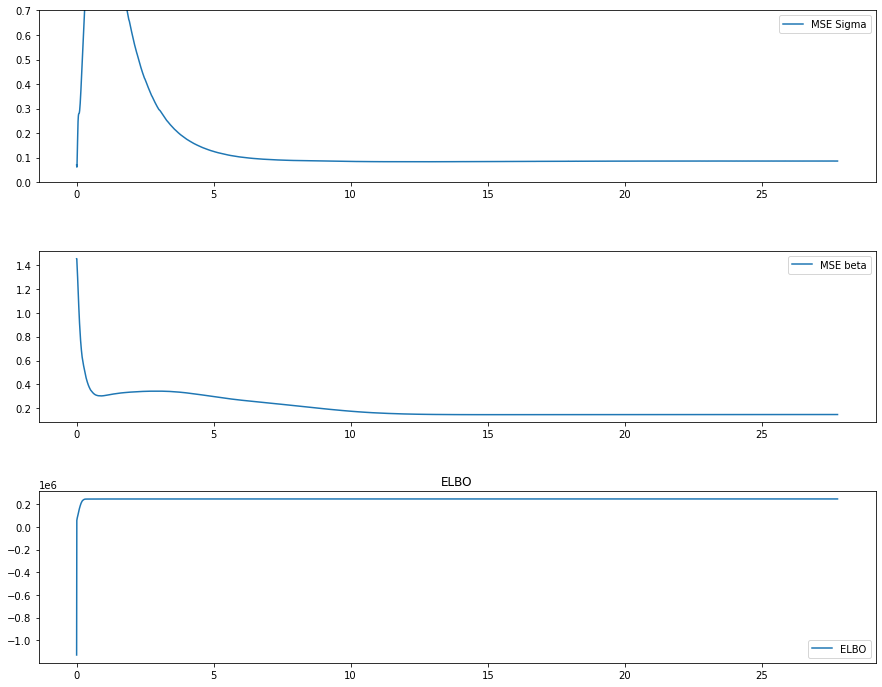

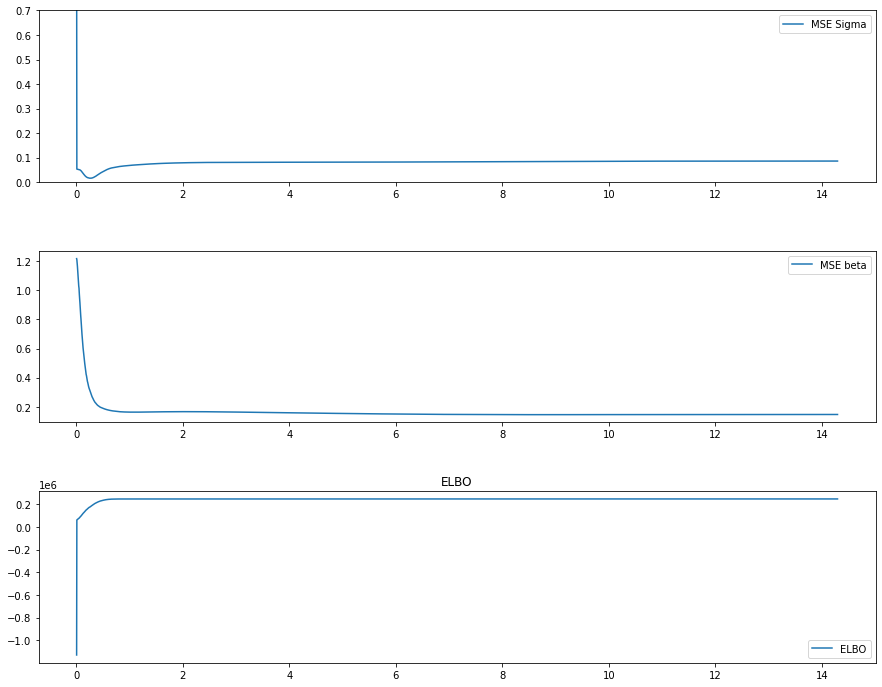

In [202]:
print_model(model)
print_model(model_VEM)

Here we have a PLN model described as the following : 

- Consider $n$ sites $(i=1 \ldots n)$

- Measure $x_{i}=\left(x_{i h}\right)_{1 \leq h \leq d}$ :
$x_{i h}=$ given environmental descriptor (covariate) for site $i$
(altitude, temperature, latitude, ...)

- Consider $p$ species $(j=1 \ldots p)$ Measure $Y=\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ :

- Measure $Y = Y_{i j}=$ number of observed individuals from species $j$ in site $i$ (abundance). 

- Associate a random vector $Z_{i}$ with each site Assume that the unknown $\left(Z_{i}\right)_{1 \leq i \leq n}$ are independant such that:
$$
Z_{i} \sim \mathcal{N}_{p}(x_i \beta, \Sigma) \quad \Sigma = CC^{\top}
$$

and $C$ is a lower triangular matrix. 
- Assume that the observed abundances $\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ are independent conditionally on the $Z=\left(Z_{i}\right)_{i}$


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
$$

Where $O = (o_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ are known offsets. 

The unknown parameter is $\theta = (C,\beta)$.

$Z$ being a latent variable, we want to use the EM algorithm to derive the maximum likelihood estimator. However, it requires to compute 

$$
\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y\right)\right]=\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y_{i}\right)\right] \propto \int_{\mathbb{R}^{p}} p_{\theta}\left(Z_{i}\right) \prod_{j} p_{\theta}\left(Y_{i j} \mid Z_{i j}\right) \mathrm{d} Z_{i}
$$ which is intractable in practice. 

We thus choose the variationnal approximation. We set

$$ 
q^{\star} = \underset{q \in \mathcal{Q_{gauss}}}{\operatorname{argmax}} J_{\theta,q}(Y) 
$$
<br>
$$
\begin{align} J_{\theta, q}(Y)& =\log p_{\theta}(Y)-K L\left[q(Z) \| p_{\theta}(Z \mid Y)\right]                                    \\ 
                              & = \mathbb{E}_{q}\left[\log p_{\theta}(Y, Z)\right] \underbrace{-\mathbb{E}_{q}[\log q(Z)]}_{\text {entropy } \mathcal{H}(q)}    \end{align}
$$

where 

$$
\mathcal{Q}_{\text {Gauss }}=\{
q=\left(q_{1}, \ldots q_{n}\right), q_{i} \sim \mathcal{N}\left(M_{i}, \operatorname{diag} (S_{i}\odot S_i ), M_i \in \mathbb{S} ^p, S_i \in \mathbb{R} ^p\right)\}
$$


The Variational EM (VEM) consists in alternate between two steps : 
- VE step: update $q$
$$
q^{h+1}=\underset{q \in \mathcal{Q_{gauss}}}{\arg \max } J_{\theta^{h}, q}(Y)=\underset{q \in \mathcal{Q_{gauss}}}{\arg \min } K L\left[q(Z) \| p_{\theta^{h}}(Z \mid Y)\right]
$$
- M step: update $\theta$
$$
\theta^{h+1}=\underset{\theta}{\arg \max } J_{\theta, q^{h+1}}(Y)=\underset{\theta}{\arg \max } \mathbb{E}_{q^{h+1}}\left[\log p_{\theta}(Y, Z)\right]
$$

Let's compute the ELBO $J_{\theta, q}(Y)$


$$
J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_{i}\right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i j}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+Z_{i j}\right)-\exp \left(o_{i j}+Z_{i j}\right)\right] + cst
\end{align}
$$

We need to compute some moments of $Z$ under $q$. 

$$
\mathbb{E}_{q}\left[Z_{i j}\right]=M_{i j} \quad \quad E_{q}\left[\operatorname{exp}\left(Z_{i j}\right)\right]=\frac{1}{2} \operatorname{exp}\left(M_{i j}+\frac{(S_{ij})^2}{2}\right)
$$

So that 

$$
\begin{aligned}
(1) &=\sum_{i, j} Y_{i j}\left(o_{i j}+M_{i j}\right)-\frac{1}{2} \exp \left(o_{i j}+M_{i j}+\frac{(S_{i_{jj}})^2}{2}\right) + cst \\
&=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S \odot S}{2}\right)\right)\mathbb{1}_p + cst 
\end{aligned}
$$



Where we have denoted $M = (M_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ and $ S = (S_{ij})_{1\leq i\leq n, 1\leq j\leq p}$. The exponential is applied pointwise on the last equation. 

$$
\begin{aligned}
(3)=H(q) &=\sum_{i} H\left(q_{i}\right) \\
&=\sum_{i} \log \left(\sqrt{(2 \pi e)^{p}\left|S_{i}\right|}\right) \\
&=\frac 12\sum_{i} \log \left|(S_{i} \odot S_i)^2 \right|+cst \\
&=\sum_{i j} \log S_{i j}+cst \\
& =  \mathbb{1}_n ^{\top}(\log S )\mathbb{1}_p+cst\\
\end{aligned}
$$

Where the log is applied pointwise at the last equation. 

$$
\begin{aligned}
(2)=\mathbb{E}_{q}\left[\log p_{\theta}(Z)\right] &=\sum_{1} E_{q}\left[\log p_{\theta}\left(Z_{i}\right)\right] \\
&=-\frac{n}{2} \log |\Sigma|+\sum_{i} \mathbb{E}_{q}\left[-\frac{1}{2}\left(Z_{i}-X_{i} \beta\right)^{\top} \Sigma^{-1}\left(Z_{i} - X_{i} \beta\right)\right] +cst
\end{aligned}
$$

$
\text { Let } V \sim \mathcal{N} \left(\mu, \Lambda), \mu \in \mathbb{R}^{p}, \Lambda \in \mathcal S _p ^{++}\right.  \\
\text { Let's compute } \; \mathbb{E}\left[V^{\top} \Sigma^{-1} V\right]
$

We denote $\Sigma ^{-1 / 2}$ the square root Matrix of $\Sigma^{-1}$. It exists since $\Sigma ^{-1} \in \mathcal{S}_p^{++}$. 

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\left[V^{\top}\Sigma ^{-1 / 2} \Sigma^{-1 / 2} V\right]\\
&=\mathbb{E}\left[\left(\Sigma^{-1 / 2} V\right)^{\top}\left(\Sigma^{-1 / 2} V\right)\right] \\
&=\mathbb{E} \|\Sigma^{-1 / 2} V \|_{2}^{2}
\end{aligned}
$$

$
\text {Let } \tilde{V}=\Sigma^{-1 / 2} V, \quad \tilde{V} \sim \mathcal{N}\left(\Sigma^{-1 / 2} \mu,  \Sigma^{-1 / 2} \Lambda \Sigma^{-\frac{1}{2}}\right)
$

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\|\widetilde{V}\|_{2}^{2} \\
&=\sum \mathbb E \widetilde{V}_{j}^{2} \\
&=\sum \operatorname{var}\left(\widetilde{V}_{j}\right)^{2}+\mathbb{E}\left[\widetilde{V}_{j}\right]^{2}\\
&=\sum_{j}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)_{j j}+\left(\Sigma^{-1 / 2} \mu\right)^{2}_j\\
&= \operatorname{tr}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1 / 2}\right)^{\top} \mu\right)^{2}\\
&=\operatorname{tr}\left(\Sigma^{-1} \Lambda\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1/2}\right)^{\top} \mu\right)^2
\end{aligned}
$$

Since under $q$, $Z_{i}-X_{i} \beta \sim \mathcal N (M_i - X_i \beta, S_i \odot S_i ) $
$$
\begin{aligned}
(2) &=- \frac 12 \sum_{i} \operatorname{tr}\left(\Sigma^{-1} (S_{i} \odot S_i) \right) - \frac 12 \sum_{i, j}\left(\left(\Sigma_{j,.}^{-1 / 2} \right) ^{\top}\left(M_{i}-X_{i} \beta\right)\right)^2  - \frac n2 \log |\Sigma|+ cst  \\
&= - \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i}\odot S_i \right)\right) - \frac 12 \sum_{i, j}\left(\Sigma^{-1 / 2}(M-X \beta)\right)_{j, i}^{\top}\left(\Sigma
^{-1 / 2}(M-X \beta)\right)_{i, j}  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i} \odot S_i  \right)\right)- \frac 12 \operatorname{tr}\left(\Sigma^{-1 / 2}(M-X \beta)^{\top}(M-X \beta) \Sigma^{-1 / 2}\right)  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right)  - \frac n2 \log |\Sigma|+ cst 
\end{aligned}
$$
We then have : 


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$

In [170]:
def f(x) : 
    return x**2

x = torch.tensor([8.])
x.requires_grad_(True)
test_optim = torch.optim.SGD([x], lr = 2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(test_optim, factor = 0.5, patience = 1)

for i in range(100): 
    
    print('normalement : ',x-2*test_optim.param_groups[0]['lr']*x)
    loss = f(x)
    loss.backward()
    test_optim.step()
    scheduler.step(loss.item())
    test_optim.zero_grad()
    print('lr : ', test_optim.param_groups[0]['lr'])
    print('x : ', x )
    

normalement :  tensor([-24.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([-24.], requires_grad=True)
normalement :  tensor([72.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([72.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([216.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], 